# COSC2779 Assignment 1

### August 2024

### By: Harold Davies / s3997902

## Introduction <a id='intro'></a>

This assignment is aimed at producing a high performing model for classifying a) human actions in still images which have not yet been seen by the model and b) whether there are multiple people in the image. A secondary aim is to minimise computational resources required for model training. A set of 4500 labelled images are available for model training and the final model will be assessed (by RMIT) against another set of 3128 unlabelled images. Transfer learning is allowed, however some part of the model needs to be further developed and tuned, with justification provided for each decision made in the development and tuning processes. **Justifications for decisions are highlighted in bold for ease of grading**.

### Human Action Recognition

Human action recognition (HAR) is an application of AI which has multiple real world use cases. HAR involves identifying the action being performed by a person in images or video footage and is helpful in situations such as sercurity surveillance and image search/retrieval. Developing HAR models which are highly accurate using just images alone, as opposed to video footage, is valuable due to the limited computing resorces available to some edge IoT devices such as CCTV cameras.

### Data Source

The images and target features for this project were sourced from the Stanford 40 Actions Dataset which was published in the report "Human Action Recognition by Learning Bases of Action Attributes and Parts" by B. Yao, X.Jiang, A. Khosla, A.L. Lin, L.J. Guibas, and L. Fei-Fei in the Internation Conference on Computer Vision (ICCV) in Barcelona, Spain on November 6-13, 2011. An additional feature named HighLevelCategory has been added to the data by Dr Ruwan Tennakoon, Senior lecturer in Artificial Intelligence at RMIT University. The image dataset used for this project is not permitted to be shared publicly, including on GitHub.

### Dataset Details and Features

The dataset contains images for training the model and images for future predicitons. Images range in size and shape, from minimum heights and widths of 200 up to maximums of 989 and 965 respectively and shapes including landscape, portrait and square.

The subset for model training contains 4500 images. Labels for the images have been provided in CSV files containing image file names in the format IMG_<#>.jpg and 3 labels: Class, MoreThanOnePerson and HighLevelCategory. The classes for prediction include 40 classes, and the distribution of classes is not uniform with the largest classses containing 222 and 157 images (applauding and holding an umbrella) whilst the smallest contain only 67 images (text messaging and washing dishes). There are 10 high level categories which the images are also not uniformly distributed within, the largest being Social Leisure Activity (866 images) and the smallest Personal Care/Hygiene (140). Each class of image belongs to only one high level category. The MoreThanOnePerson column contains values YES and NO with 2830 images containing only one person. This information is particularly relevant to HAR as images with mlore than 1 person are usually more difficult for models to classify.

The subset for future predicitons contains 3128 images, for which a CSV with only file names has been provided.

### Target Features

This project has two target features: Class and MoreThanOnePerson

### Goals and Objectives / Evaluation Framework

Goals of this project are as follows:

* Produce the highest possible accuracy for classes averaged with accuracy for MoreThanOnePerson on a test dataset using the hold out method
* Acheive this with the simplest possible model (for better accuracy and lower computational requirement)
* Produce a reliable model which is likely to generalise well to images from a different dataset
* Predict the target features of the future predicitons data subset

Evaluation framework **justification**:

Whilst the classes being predicted contain significant class imbalance, we **aren't particularly concerned with bias between classes**, especially as this dataset is used as a benchmark for computer vision model performance. F1 and AUC score were considered as potential metrics which offer better sensitivity to class imbalance, however **accuracy has been selected for simplicity** and the **ability to compare** with models from academic papers.

### Proposed methodology

* Select base model
* Data loading and imports
* Exploration and visualisation
* Cleaning and preprocessing
* Train-test split
* Loading and augmentation
* Load base model
* Head architecture selection
* Hyper-parameter tuning
* Base model tuning
* Evaluation of validation results (selection of best model)
* Predict for test data & evaluate
* Predict for future data

### Pretrained model (PTM) selection and details

When it comes to selecting a pre-trained model to use for our problem, the best practise is to consider which model architecture has acheived the best results on similar problems. The dataset for this project was released in November, 2011, and since then, many teams of deep learning professionals have worked to develop the best performing model for categorising images in the dataset. Whilst many teams have acheived accuracies of over 90% (94.7% - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10280426/, 93.8% - https://ieeexplore.ieee.org/abstract/document/9765465/references#references, 94.8% - https://link.springer.com/article/10.1007/s11042-023-14350-z) the methods involved ensembles of models, attention mechanisms and multi-step processses such as local feature extraction and selection during preprocessing. These methods are considered outside the scope of this project, which is concerned with using a single pretrained CNN model together with a head, fine tuned on the available HAR images.

Some models considered for this project which achieved respectable results on the Stanford40 dataset include:
* ResNet-50
* Inception-V3
* VGG19
* Inception-ResNet-V2
* EfficientNet

Two papers which were used to gauge the relative performance of the models include "Ensembled Transfer Learning Based Multichannel Attention Networks for Human Activity Recognition in Still Images" - 2022 (https://ieeexplore.ieee.org/abstract/document/9765465/citations#citations) and "Activity Recognition with Still Images and Video" - 2020 (https://cs230.stanford.edu/projects_winter_2020/reports/32636548.pdf). Whilst the 2022 paper ultimately considers a more advanced approach, they first tested the base models being considered against a range of datasets including Stanford40 without use of ensembling or an attention module. **EfficientNetB7 was the highest performing model followed by InceptionResNetV2**. Although the paper was useful to compare base models, as the focus of the paper was on the more complex implementation, they **do not go into detail on the procedure** followed to implement the base models. In the earlier **paper by Wendell Hom, 6 models were compared** included VGG16 and VGG19, ResNet-50, MobileNet-v2, Inception-ResNet-v2, and Inception-v3. These architectures were fine-tuned using the Stanford40 dataset and **Inception-ResNet-v2 was** determined to be the **best performing model**.

**InceptionResNetV2 achieved 71.6% accuracy on Stanford40** in Hom's paper on 224x224 images, with a **methodology** which is **well explained** and suitable to apply for this project. Their accuracy was further improved to 84.7% by using a 2-branch model with a human mask component which identifies the part of the image containing the human first, so that the second branch can better identify the human action by focussing on the relevant part of the photo. In this report we will just use a single branch model, however we will also be predicting a second target feature.

In the aforementioned paper, **images were preprocessed for the Inception-ResNet-v2 model as follows**:

* images were rescaled to match model input shape - 224x224x3
* augmentation: horizontal flipping, 10 degrees of rotation range and 0.9-1.1 zoom
* ImageNet pre-training weights were used
* the final layer was replaced with a 40-way softmax output layer
* trained using the Adam optimizer initially with 0.0001 learning rate reduced to 0.00005 then 0.00001 as training loss saturated

## Data Preperation

### Loading and imports

Random seed is implemented to ensure repeatability of results

In [1]:
#imports and random seed
rand = 4
import random
random.seed(rand)
import os
import datetime
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

Google drive is mounted for access to images, CSVs, etc.

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Images and CSVs were stored locally with the notebook for quicker access.

In [3]:
#copy zip file to notebook local disk, unzip it and remove the zip file
!cp /content/drive/'My Drive'/DeepLearningAss1/data/images/Images.zip .
!unzip -q Images.zip
!rm Images.zip
#create the data and image folders
!mkdir data
!mkdir data/images
#copy csv files into data folder
!cp /content/drive/'My Drive'/DeepLearningAss1/data/train_data_2024.csv ./data
!cp /content/drive/'My Drive'/DeepLearningAss1/data/s3997902_predictions.csv ./data
#move unziped images into image folder
!mv Images/* data/images
#delete misc folder from unzipping process
!rm -rf Images
#images and CSVs are now in the desired folder structure
!ls data/

images	s3997902_predictions.csv  train_data_2024.csv


A pickle file was used to keep an up to date record of model results between sessions. This is commented out as it was only implemented after the first models had been trained.

In [78]:
# #location of pickle file
# file_path = '/content/drive/My Drive/Colab Notebooks/m_history.pkl'

# #load the m_history dictionary
# with open(file_path, 'rb') as file:
#     m_history = pickle.load(file)

In [4]:
#load training data
metadata_path = 'data/train_data_2024.csv'
image_data = pd.read_csv(metadata_path)

In [5]:
#load predicition file
metadata_path2 = 'data/s3997902_predictions.csv'
prediction_data = pd.read_csv(metadata_path2)

### Exploration and Visualisation

First I have a look at the general format of the training csv data

In [ ]:
#inspect first 5 rows of training data
image_data.head()

FileName              Class MoreThanOnePerson  \
0   Img_460.jpg    blowing_bubbles               YES   
1  Img_8152.jpg    blowing_bubbles               YES   
2  Img_9056.jpg            jumping               YES   
3  Img_3880.jpg     pushing_a_cart               YES   
4  Img_3168.jpg  writing_on_a_book                NO   

            HighLevelCategory  
0    Social_LeisureActivities  
1    Social_LeisureActivities  
2           Sports_Recreation  
3           OutdoorActivities  
4  Artistic_MusicalActivities

Note here that the images are not sorted according to any of the features. Next I check how many rows are in the csv file

In [ ]:
#check number of rows
image_data.shape

(4500, 4)

Next I want to check the distribution of images across each Class to see if there is any imbalance. I'm saving space by just looking at the head and tail which are of interest to see the max and min quantities of images in classes.

In [ ]:
#check class distribution - largest classes
image_data['Class'].value_counts().head()

Class
applauding             222
holding_an_umbrella    157
climbing               155
cooking                153
riding_a_horse         153
Name: count, dtype: int64

In [ ]:
#smallest classes
image_data['Class'].value_counts().tail()

Class
brushing_teeth        73
rowing_a_boat         72
writing_on_a_board    69
texting_message       67
washing_dishes        67
Name: count, dtype: int64

Note there is quite significant imbalance with the largest class, applauding, containing >3x as many images as the smallest class, washing dishes. Next I am interested to know how many Classes there are in total.

In [ ]:
#number of classes
image_data['Class'].nunique()

40

I will also check the distribution of images across the high level categories.

In [ ]:
#check distribution of high level categories
image_data['HighLevelCategory'].value_counts()

HighLevelCategory
Social_LeisureActivities      866
OutdoorActivities             749
Artistic_MusicalActivities    658
Sports_Recreation             616
HouseholdActivities           402
MaintenanceRepair             309
Communication_Technology      303
AnimalCare                    295
Observation_Exploration       162
PersonalCare_Hygiene          140
Name: count, dtype: int64

Again, there is significant imbalance with the largest category, Aocial Leisure Activities, containing >6x as many images as the smallest category, Personal Care Hygiene. Also note there are 10 high level categories in total. Next I check for imbalance in the More than one person feature as well as the number of unique values.

In [ ]:
#check distribution of binary "more than one person" feature
image_data['MoreThanOnePerson'].value_counts()

MoreThanOnePerson
NO     2830
YES    1670
Name: count, dtype: int64

There is only moderate imbalance here, which suggests accuracy will be suitable enough for measuring prediction performance on this feature. I also note from the above outputs that there are no typos or errors visible in the csv file values based on the unique values shown. Next I check for missing values.

In [ ]:
#check for missing values
image_data.isna().sum()

FileName             0
Class                0
MoreThanOnePerson    0
HighLevelCategory    0
dtype: int64

There are no missing values present in the csv file. Now we can take a look at the predicition csv file, read it in and check its shape.

In [ ]:
#check shape of predicition file
prediciton_data.shape

(3128, 3)

The prediction file has only 3 columns and 3128 rows, let's have a look at its format.

In [ ]:
#inspect prediction file values
prediciton_data.head()

FileName  Class  MoreThanOnePerson
0  Img_1963.jpg    NaN                NaN
1  Img_7244.jpg    NaN                NaN
2  Img_6218.jpg    NaN                NaN
3  Img_7703.jpg    NaN                NaN
4  Img_6318.jpg    NaN                NaN

We see here only the FileName, Class and MoreThanOnePerson columns are included, i.e. the reference to the features we will use to make predictions (images) and the target features. The values needing to be predicted are represented by NaN values. Next we will visualise some of the images to inspect the dataset quality, features, etc.

In [ ]:
#36 random rows from the DataFrame
sampled_data = image_data.sample(n=36, random_state=rand)

#create a 6x6 grid
fig, axes = plt.subplots(6, 6, figsize=(20, 20))

#flatten the axes array for easy iteration
axes = axes.flatten()

#loop through the axes and the sampled data
for ax, (index, row) in zip(axes, sampled_data.iterrows()):
    # Open the image file
    img_path = os.path.join('data/images', row['FileName'])
    img = Image.open(img_path)

    #display the image
    ax.imshow(img)

    #set the title with metadata
    ax.set_title(f"{row['FileName']}\n{row['Class']}\n>1 Person: {row['MoreThanOnePerson']}\nHLC: {row['HighLevelCategory']}")
    ax.axis('off')  # Hide axes

#adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#output removed for github publication as images are not licensed for redistribution

Some interesting characteristics:
* Img 5099 & 6121: only 1 person in image yet MoreThanOnePerson = YES
* Features of interest are not always in the centre of the image, frequently other people or items like TVs and climbing holds are located near or on the edge of the image
* The problem is not just about identifying people and their gestures and actions but also other items such as umbrellas, cars or horses.
* Img 4372 and 8505: appear to be indoor climbing labelled with high level category 'OutdoorActivities'
* brightness and contrast appear fairly consistent which would allow a margin for augmentation
* images vary is shape from landscape to portrait and square

It is worth noting that during the data exploration phase of this project, the images were also viewed directly using windows explorer to glean insights from a larger quantity of the images. Lets visualise a few more images to get a more complete impression of the dataset.

In [ ]:
#36 different random rows from the DataFrame
sampled_data = image_data.sample(n=36, random_state=rand+1)

#create a 6x6 grid
fig, axes = plt.subplots(6, 6, figsize=(20, 20))

#flatten the axes array for easy iteration
axes = axes.flatten()

#loop through the axes and the sampled data
for ax, (index, row) in zip(axes, sampled_data.iterrows()):
    #open the image file
    img_path = os.path.join('data/images', row['FileName'])
    img = Image.open(img_path)

    #display the image
    ax.imshow(img)

    #set the title with metadata
    ax.set_title(f"{row['FileName']}\n{row['Class']}\n>1 Person: {row['MoreThanOnePerson']}\nHLC: {row['HighLevelCategory']}")
    ax.axis('off')  # Hide axes

#adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#output removed for github publication as images are not licensed for redistribution

The images will need to be resized to a consistent size to be input into a deep neural network, so I am interested to know the sizes of the images.

In [ ]:
#directory containing images
image_dir = 'data/images'

#initialize variables to track max and min width and height
max_width = 0
max_height = 0
min_width = float('inf')  #initialize to a very large value
min_height = float('inf')  #initialize to a very large value

#loop through all images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            if width > max_width:
                max_width = width
            if height > max_height:
                max_height = height
            if width < min_width:
                min_width = width
            if height < min_height:
                min_height = height

#output the maximum and minimum width and height
print("Maximum Width:", max_width)
print("Maximum Height:", max_height)
print("Minimum Width:", min_width)
print("Minimum Height:", min_height)

Maximum Width: 997
Maximum Height: 965
Minimum Width: 200
Minimum Height: 200


We see here that the maximum image height and width are 965 and 989 pixels, and the minimum height and width is 200 pixels. Ideally we don't want to increase image size as it can distort the features in the images, but reducing image size is acceptible. Given the most common image input size to neural networks is 224x224, the image sizes seen above will be suitable for resizing to this size, with consideration made to the resizing procedure.

### Preprocessing

For data input to tensorflow, binary features need to be represented by 0 and 1, and when we make final predictions we will need to convert the binary output back to YES and NO, so we will save a mapping of Yes/No values to 1/0 values for later use and use it to change values to the required format.

In [6]:
#update binary feature to integer values and store mappings
label2_map = {label: idx for idx, label in enumerate(image_data['MoreThanOnePerson'].unique())}
image_data['MoreThanOnePerson'] = image_data['MoreThanOnePerson'].map(label2_map)

Categorical values need to be one-hot encoded for input to a tensorflow model. I establish a **class mapping** here which **is critical to ensuring consistent use of classes** throughout the project.

In [7]:
#create class mapping before one-hot encoding
class_mapping = {idx: class_name for idx, class_name in enumerate(image_data['Class'].unique())}

#one hot encode categorical feature
one_hot_encoded_classes = pd.get_dummies(image_data['Class'], prefix='Class')
image_data = pd.concat([image_data, one_hot_encoded_classes], axis=1)

image_data.head()

FileName              Class  MoreThanOnePerson  \
0   Img_460.jpg    blowing_bubbles                  0   
1  Img_8152.jpg    blowing_bubbles                  0   
2  Img_9056.jpg            jumping                  0   
3  Img_3880.jpg     pushing_a_cart                  0   
4  Img_3168.jpg  writing_on_a_book                  1   

            HighLevelCategory  Class_applauding  Class_blowing_bubbles  \
0    Social_LeisureActivities             False                   True   
1    Social_LeisureActivities             False                   True   
2           Sports_Recreation             False                  False   
3           OutdoorActivities             False                  False   
4  Artistic_MusicalActivities             False                  False   

   Class_brushing_teeth  Class_cleaning_the_floor  Class_climbing  \
0                 False                     False           False   
1                 False                     False           False   
2                 False                     False           False   
3                 False                     False           False   
4                 False                     False           False   

   Class_cooking  ...  Class_taking_photos  Class_texting_message  \
0          False  ...                False                  False   
1          False  ...                False                  False   
2          False  ...                False                  False   
3          False  ...                False                  False   
4          False  ...                False                  False   

   Class_throwing_frisby  Class_using_a_computer  Class_walking_the_dog  \
0                  False                   False                  False   
1                  False                   False                  False   
2                  False                   False                  False   
3                  False                   False                  False   
4                  False                   False                  False   

   Class_washing_dishes  Class_watching_TV  Class_waving_hands  \
0                 False              False               False   
1                 False              False               False   
2                 False              False               False   
3                 False              False               False   
4                 False              False               False   

   Class_writing_on_a_board  Class_writing_on_a_book  
0                     False                    False  
1                     False                    False  
2                     False                    False  
3                     False                    False  
4                     False                     True  

[5 rows x 44 columns]

  ### Train-Test Split

I will use the hold out technique to ensure that the data which my final model is tested on (test data) is never seen by the model during the training process. In addition I will use a **validation set to monitor overfitting and underfitting** during the training process. **50 / 20 / 30 is a good starting point** according to industry standard as long as you **have a sufficiently large dataset** for model training, which in this case **we do, especially after we will make use of data augmentation**. k-fold cross validation would be another option if we had a smaller dataset, but would make the training process more computationally expensive as it uses multiple iterations of training and testing the data as opposed to just 1.

Another decision made here is to **use stratification**, this ensures a consistent distribution of classes across each split of the data.

In [80]:
#temp data is saved and split into val and test datasets
train_data, temp_data = train_test_split(image_data, test_size=0.5,
                                         random_state=4,
                                         stratify=image_data['Class'])
val_data, test_data = train_test_split(temp_data, test_size=0.6, random_state=4,
                                       stratify=temp_data['Class'])

train_data.head()

FileName                Class  MoreThanOnePerson  \
866      Img_3.jpg             climbing                  1   
3581  Img_6033.jpg              reading                  1   
777   Img_1812.jpg  holding_an_umbrella                  0   
679   Img_9018.jpg    writing_on_a_book                  1   
4324  Img_2919.jpg        cutting_trees                  1   

               HighLevelCategory  Class_applauding  Class_blowing_bubbles  \
866            OutdoorActivities             False                  False   
3581  Artistic_MusicalActivities             False                  False   
777                   AnimalCare             False                  False   
679   Artistic_MusicalActivities             False                  False   
4324           MaintenanceRepair             False                  False   

      Class_brushing_teeth  Class_cleaning_the_floor  Class_climbing  \
866                  False                     False            True   
3581                 False                     False           False   
777                  False                     False           False   
679                  False                     False           False   
4324                 False                     False           False   

      Class_cooking  ...  Class_taking_photos  Class_texting_message  \
866           False  ...                False                  False   
3581          False  ...                False                  False   
777           False  ...                False                  False   
679           False  ...                False                  False   
4324          False  ...                False                  False   

      Class_throwing_frisby  Class_using_a_computer  Class_walking_the_dog  \
866                   False                   False                  False   
3581                  False                   False                  False   
777                   False                   False                  False   
679                   False                   False                  False   
4324                  False                   False                  False   

      Class_washing_dishes  Class_watching_TV  Class_waving_hands  \
866                  False              False               False   
3581                 False              False               False   
777                  False              False               False   
679                  False              False               False   
4324                 False              False               False   

      Class_writing_on_a_board  Class_writing_on_a_book  
866                      False                    False  
3581                     False                    False  
777                      False                    False  
679                      False                     True  
4324                     False                    False  

[5 rows x 44 columns]

In [ ]:
train_data.shape

(2250, 44)

In [ ]:
val_data.shape

(900, 44)

In [ ]:
test_data.shape

(1350, 44)

A consistent distribution of classes acros the 3 datasets is ensure by using stratification, however a consistent distribution of MoreThanOnePerson is not ensured, so I will plot these distributions to check them for consistency.

In [10]:
# Count values for MoreThanOnePerson (0s and 1s) in each dataset
train_counts = train_data['MoreThanOnePerson'].value_counts()
val_counts = val_data['MoreThanOnePerson'].value_counts()
test_counts = test_data['MoreThanOnePerson'].value_counts()

# Create a plot
fig, ax = plt.subplots()

# Define bar width and positions
bar_width = 0.25
bar_positions = [0, 1]

# Plotting the bars
ax.bar([p - bar_width for p in bar_positions], train_counts, width=bar_width, label='Train', color='lightblue')
ax.bar(bar_positions, val_counts, width=bar_width, label='Validation', color='lightgreen')
ax.bar([p + bar_width for p in bar_positions], test_counts, width=bar_width, label='Test', color='salmon')

# Adding labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(['0', '1'])
ax.set_xlabel('MoreThanOnePerson (0: No, 1: Yes)')
ax.set_ylabel('Count')
ax.set_title('Distribution of MoreThanOnePerson Across Datasets')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

A quick scan of this plot tells us that the distribution of images with 1 and more than 1 person is consistent across the 3 datasets.

### Loading and augmentation

A batch size of **32 is a common industry practice**, with other sizes such as 64, or even larger, also being reasonable. The impact on model performance typically varies, with larger batch sizes potentially leading to faster convergence but sometimes requiring more memory. Given the relatively low-performance hardware being utilized for this project, a **smaller batch size** might be **preferable to manage memory usage and avoid potential bottlenecks**. This parameter will not be tuned.

In [8]:
BATCH_SIZE = 32

ImageDataGenerator is a TensorFlow library that provides powerful capabilities for augmenting images in a dataset by creating transformed versions of the original images. These transformations can include rotations, shifts along the x and y axes, horizontal or vertical flips, brightness adjustments, and skewing (shearing) the image along an axis (rectangle -> parallelogram). It also allows for color channel shifting, which adjusts the intensity of the red, green, or blue channels independently.

However, **not every transformation is relevant** or appropriate for this specific training set. For instance, flipping images vertically (turning them upside down) may not make sense for action recognition, as it could confuse the model by introducing unrealistic scenarios. Therefore, only horizontal flipping has been considered, while vertical flipping has been omitted to maintain the logical orientation of the images.

**In Hom's paper** referenced above, **certain image augmentations were outlined** which were used to achieve the high accuracy score of 71.6% and these augmentation methods will also be used here:
* resize to 224x224x3
* horizontal flipping
* rotation range of 10 degrees
* zoom range of 0.9-1.1


* Custom dataloader - **allow for multiple target features**
* Use class_mapping - ensure the **class labels are accurately mapped to one-hot-encoded columns **. This is **crucial for correctly mapping the predicted and true labels** to the right categories in the DataFrame.
* Data augmentation - Artificially increases the size of our dataset and enhances diversity of images which **regularises the model and  improves model generalisation**
* Normalise - tensorflow works best with values between 0 and 1 (e.g. **reduced saturation** of neuron output values which **aids in effective training**)
* Batch processing - the image set is simply too large to load all at once, batch processing is **far more efficient**
* Shuffling data - **prevent the model learning from the order of images**



In [9]:
#create an ordered list of class names
ordered_class_names = [class_mapping[i] for i in range(len(class_mapping))]

#update the category_columns based on the ordered class names
category_columns = [f'Class_{class_name}' for class_name in ordered_class_names]

#define custom function for loading data
def custom_data_loader(data_frame, datagen, batch_size=BATCH_SIZE,
                       img_dir='./data/images/', target_size=(224, 224)):
    while True:
        indices = np.random.permutation(data_frame.index)
        for start in range(0, len(data_frame), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            batch_data = data_frame.loc[batch_indices]

            images = []
            category_labels = []
            binary_labels = []

            for _, row in batch_data.iterrows():
                img_path = f"{img_dir}/{row['FileName']}"
                img = tf.keras.preprocessing.image.load_img(img_path,
                                                            target_size=target_size)
                img = tf.keras.preprocessing.image.img_to_array(img)

                #apply augmentation
                img = datagen.random_transform(img)
                img = img / 255.0

                images.append(img)
                category_labels.append(row[category_columns].values.astype(np.int8))
                binary_labels.append(np.int8(row['MoreThanOnePerson']))

            yield np.array(images), {'category_output': np.array(category_labels),
                                     'binary_output': np.array(binary_labels)}


In [81]:
#train data with augmentation
train_datagen = ImageDataGenerator(data_format='channels_last',
                                   rotation_range=10,
                                   zoom_range=[0.9,1.1], horizontal_flip=True,
                                   brightness_range=[0.8, 1.2])

#validation data
val_datagen = ImageDataGenerator(data_format='channels_last')

#image generators
train_generator = custom_data_loader(train_data, train_datagen)
validation_generator = custom_data_loader(val_data, val_datagen)

The best method to ensure data augmentation has only introduced useful image variations, for example brightness adjustments have not introduced images which are too bright or dark to recognise the human action taking place in the image, is to **visualise the images post-augmentation**. Here I visualise the first batch to check the augmentations are appropriate.

In [ ]:
#get a batch of images and labels from the generator
images, labels = next(train_generator)

#plot the images
plt.figure(figsize=(12, 12))

for i in range(len(images)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()

#output removed for github publication as images are not licensed for redistribution

Above, we can see the first training batch of images post augmentation. Despite the many distortions in brightness, aspect, zoom and rotation, it is still evident which human action is taking place in each image. Importantly, these **distortions represent realistic variations in images** that could be due to weather, camera setting, etc.

## Predictive modeling

### Loading base model

Selection of a vanilla model or a specific base model for transfer learning is a critical decision which will decide the final model performance which can be achieved. **Due to the relatively small size of the Stanford40 set of images, transfer learning is a considerably better option** than using a model developed from scratch, due to their ability to capture complex features by leveraging the **combination of their deep architecture and pre-trained weights on larger datasets** such as ImageNet. I have **selected the Inception-Resnet model, as discussed in the introduction, due to its high performance on the Stanford40 dataset** compared to other models such as ResNet50 and VGG19. The Inception-ResNetV2 model is an advancement of the ResNet model, introducing Inception blocks that allow for greater image complexity to be captured by the neural network, while still leveraging ResNet's features that enable the model to scale its depth and achieve the appropriate level of complexity.

Image size **224x224** is the required size for input images as this is the **size of images which the model was originally trained on** (ImageNet) and so mimicing this image size will achieve the best results, and also will involve very **minimal scaling up of our image sizes**. I will use pre-trained weights in order to leverage training which was completed on the model with a much larger image set containing similar features to that of our set of images.

I set **trainable to false** as the model is very large, has already been trained, and would require immense computational power to train. It also would not make sense to change the layers of the CNN which have **already been trained to detect useful features**.

Not including the top as I need to customise this to our prediciton requirements. ImageNet is a sensible choice for weights because the images in **ImageNet contain features** (e.g. people, cars, bicycles, etc.) which are **important for our problem**.

In [11]:
# Define the input shape
IMG_SHAPE = (224, 224, 3)

# Load the InceptionResNetV2 model with imagenet weights and no top layers
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


It is best to inspect the model layers to inform later decisions regarding options for further fine tuning. The model layers were inspected below, however, this table consumed 35 pages when printing this notebook to pdf which put it over the page limit for printing, therefore it has been commented out for the purposes of the pdf export.

In [ ]:
# base_model.summary()

Note the various blocks (identifiable by layers labelled with block names e.g. block35_<#>, block 17_<#>, block8_<#>) which consist of convolutional layers, batch normalisation layers, activation layers, mixed blocks and final convolution and activation layers.

### Head architecture selection

Architecture decisions:

Common layers:
* Layer widths 2^n - using layer widths which are a power of 2 is **common practise** in neural network development **for many reasons** including memory alignment, cache optimisation, historical precdent, easy scaling (can always halve) and optimal GPU utilisation. I will stick with this convention.
* Global average pooling - this is **standard procedure** for the start of the Inception-ResNet model head, it **reduces dimensionality** ready for the MLP layers. The other option is flattening, but that is a worse option due to the excessive width of the layer it would produce.
* Dense 1024 - I am basing many of my decisions on the paper discussed in the introduction however this is an exception to that. In the paper, **Hom used 2 x 4096** neuron layers before the softmax layer, I am going with a drastically smaller, single layer in order to satisfy the project goal of achieving **high performance** with the **simplest possible model**, knowing that I **can adjust the width and depth to be bigger if necessary**.
* Relu activation - ReLU (Rectified Linear Unit) activation is **popular in modern neural networks** because it accelerates training by reducing the likelihood of vanishing gradients compared to sigmoid activations. ReLU also prevents saturation of positive neuron outputs, which can help in mitigating the issues related to slow convergence and gradient problems that can occur with other activation functions.

Classification layers:
* Dense 256 - the model needs to classify images into one of 40 classes. Directly reducing from 1024 neurons to 40 can be a drastic reduction. Incorporating an **intermediate layer with 256 neurons allows the model to more effectively combine and process features** communicated from the lower layers. This intermediate layer helps in capturing complex patterns and interactions before making the final classification decision, potentially leading to more accurate and robust performance
* Dense 40 - this layer needs 40 neurons to **match the 40 possible class predicitons**, softmax is the **best activation method for categorical predictions** as it transforms scores of the raw output into probabilities, the sum of which is 1. This makes it possible to interpret the output as a probability distribution across the 40 classes, then the class with the highest probability is selected by the model as the predicted class.

Binary layers:
* Dense 128 and 16 - Again, reducing from 1024 to 1 is too extreme, so 2 intermediate layers are used for the **reasons described above**. The 3 reductions 1024 -> 128, 128 -> 16, 16 -> 2 (technically 1 but it represents 2 possible predictions) are all approx. 8x reductions which is why these sizes were selected, to **keep the rate of width reduction fairly consistent**.
* Dense 1 sigmoid - Sigmoid activation for a single neuron is **generally accepted** to be the **ideal way to predict a binary variable** because it outputs values between 0 and 1, which can be interpreted as probabilities. The sigmoid function provides a smooth gradient, which helps the model to effectively learn the boundaries between the two classes during training and outputs can be simply classified based on the probability using a threshold of 0.5.

In [82]:
#import function to prepare images for model input
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

#define the input layer
inputs = tf.keras.Input(shape=IMG_SHAPE)

#preprocess the input images
x = preprocess_input(inputs)

#use the base model to extract features
x = base_model(inputs, training=False)

#utilise global average pooling and a dense layer as the new model head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)

#output layers for the categorical classification task (e.g., 40 classes)
cat_x = layers.Dense(256, activation='relu')(x)
category_output = layers.Dense(40, activation='softmax',
                               name='category_output')(cat_x)

#output layers for the binary classification task
bin_x = layers.Dense(128, activation='relu')(x)
bin_x = layers.Dense(16, activation='relu')(bin_x)
binary_output = layers.Dense(1, activation='sigmoid',
                             name='binary_output')(bin_x)

#define the model with two outputs
model = models.Model(inputs=inputs, outputs=[category_output, binary_output])

There are 2 decisions to address here:
* Number of epochs has been **decided based on initial experiments** training these models, it was found through experimentation that 30 epochs is **enough to acheive maximum validation performance**. Later in the notebook I will implement early stopping, but for now I want to let the training process play out to produce learning curves which allow me to tune the model architecture, regularisation and training process
* learning rate is being set according to the previously discussed paper: "We trained these models using the Adam optimizer with an **initial learning rate of 0.0001, and reduced it to 0.00005 and then 0.00001 as the training loss saturated**." I am **simplifying** the decay rate implementation by emulating this approach **with a stepped decay** which uses these values across the 30 epochs.

In [20]:
def custom_learning_rate_scheduler(epoch, lr):
    if epoch < 10:
        return 0.0001
    elif epoch < 20:
        return 0.00005
    else:
        return 0.00001

#define the callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(custom_learning_rate_scheduler)

Compile Model decisions:
* Adam optimiser used to mimic the procedure used in the previously discussed paper. It is also generally considered to be the **best starting point** and **suitable for the majority** of model applications.
* Loss functions:
 - Binary cross entropy - **ideal for this type of task** because it quantifies how well the model's predicted probability for each class matches the actual class
 - categorical cross entropy - suitable here as it is **designed to handle the multi-class nature** of the categorical output
* Loss weighting - I am considering the prediction of the **binary and categorical features of equal importance**, and hence implementing equal weighting when the losses are combined to ensure one does not dominate the other in the training process.  
* Accuracy - as discussed in the introduction, considering the class imbalances, particularly in the human action classes, f1 score could have been a reasonable choice for metric. Accuracy was selected over f1 score for 2 reasons:

 a) while accuracy does not account for class imbalances, in this case, identifying **specific actions** (like washing dishes) is **not critically important** compared to others. Thus, a model biased towards more significant actions is not a significant concern.

 b) All related studies and papers that addressed similar tasks and datasets have used accuracy as the primary metric. Using accuracy allows for **better comparability** of results with these existing studies.

In [83]:
#compile the model with combined loss
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'category_output': 'categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              loss_weights={'category_output': 1.0, 'binary_output': 1.0},
              metrics={'category_output': 'accuracy',
                       'binary_output': 'accuracy'})

I am making a **concious decision not to save model weights**, as this is just the beginning of my training process, later I will add regularisation and early stopping, incorporating the saving of weights for the best performing model iteration. For now I will **save on memory and computation time** by not saving model weights.

Due to using a custom data loader, the model doesn't inherently know how many steps to use per epoch, so I explicitly calculate this and input it to the model when fitting. I'm also saving all model results in a library.

In [14]:
#define library for storing model results
m_history = {}

In [84]:
steps_per_epoch_train = len(train_data) // BATCH_SIZE
steps_per_epoch_val = len(val_data) // BATCH_SIZE

Everything implemented here has been discussed already.

In [85]:
#train the model with the learning rate scheduler
m_history['small_head_no_reg'] = model.fit(train_generator,
                                                epochs=30,
                                                steps_per_epoch=steps_per_epoch_train,
                                                batch_size=BATCH_SIZE,
                                                validation_data=validation_generator,
                                                validation_steps=steps_per_epoch_val,
                                                callbacks=[lr_scheduler])

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 627ms/step - binary_output_accuracy: 0.5882 - category_output_accuracy: 0.2243 - loss: 3.8715 - val_binary_output_accuracy: 0.6663 - val_category_output_accuracy: 0.5603 - val_loss: 2.3441 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 540ms/step - binary_output_accuracy: 0.6923 - category_output_accuracy: 0.6117 - loss: 2.0789 - val_binary_output_accuracy: 0.6924 - val_category_output_accuracy: 0.6613 - val_loss: 1.8198 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 436ms/step - binary_output_accuracy: 0.7126 - category_output_accuracy: 0.7050 - loss: 1.5758 - val_binary_output_accuracy: 0.7373 - val_category_output_accuracy: 0.6797 - val_loss: 1.6482 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 430ms/step - binary_output_accuracy: 0.7524 - category_output_accuracy: 0.7542 - loss: 1.3820 - val_binary_output_accuracy: 0.7373 - val_category_output_accuracy: 0.6671 - val_loss:

Extracting results from library for plotting and calculating average accuracies.

In [24]:
#function for a single plot
def plot_metric(ax, metric_name, train_metric, val_metric,
                train_label, val_label, color):
    """Plot a single metric on a given axis.
    Args:
    - ax: matplotlib axis object
    - metric_name: Title of the plot
    - train_metric: Training metric data
    - val_metric: Validation metric data
    - train_label: Label for training data
    - val_label: Label for validation data
    - color: Color of the plot lines
    """

    epochs = range(1, len(train_metric) + 1)
    ax.plot(epochs, train_metric, color + '-', label=train_label)
    #to account for final model training without val data
    if val_metric is not None:
        ax.plot(epochs, val_metric, color + '--', label=val_label)
    ax.set_title(metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

#function for a grid of results for a specific model
def plot_results(m_history):
  # Extract the history data
  history = m_history.history

  #accessing training metrics
  category_accuracy = history['category_output_accuracy']
  binary_accuracy = history['binary_output_accuracy']
  loss = history['loss']

  #accessing validation metrics
  val_category_accuracy = history.get('val_category_output_accuracy', None)
  val_binary_accuracy = history.get('val_binary_output_accuracy', None)
  val_loss = history.get('val_loss', None)

  #calculate the average accuracy and loss
  average_accuracy = np.mean([category_accuracy, binary_accuracy], axis=0)
  average_val_accuracy = np.mean([val_category_accuracy, val_binary_accuracy],
                                 axis=0) if val_category_accuracy and val_binary_accuracy else None

  #create a 2x2 grid for the plots
  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  #plot metrics  (train-only if val_* is None)
  plot_metric(axs[0, 0], 'Category Accuracy', category_accuracy,
              val_category_accuracy, 'Category Training Accuracy',
              'Category Validation Accuracy', 'b')
  plot_metric(axs[0, 1], 'Binary Accuracy', binary_accuracy,
              val_binary_accuracy, 'Binary Training Accuracy',
              'Binary Validation Accuracy', 'g')
  plot_metric(axs[1, 0], 'Average Accuracy', average_accuracy,
              average_val_accuracy, 'Average Training Accuracy',
              'Average Validation Accuracy', 'r')
  plot_metric(axs[1, 1], 'Average Loss', loss, val_loss,
              'Average Training Loss', 'Average Validation Loss', 'r')

  #adjust layout and show the plots
  plt.tight_layout()
  plt.show()

Visualising training results.

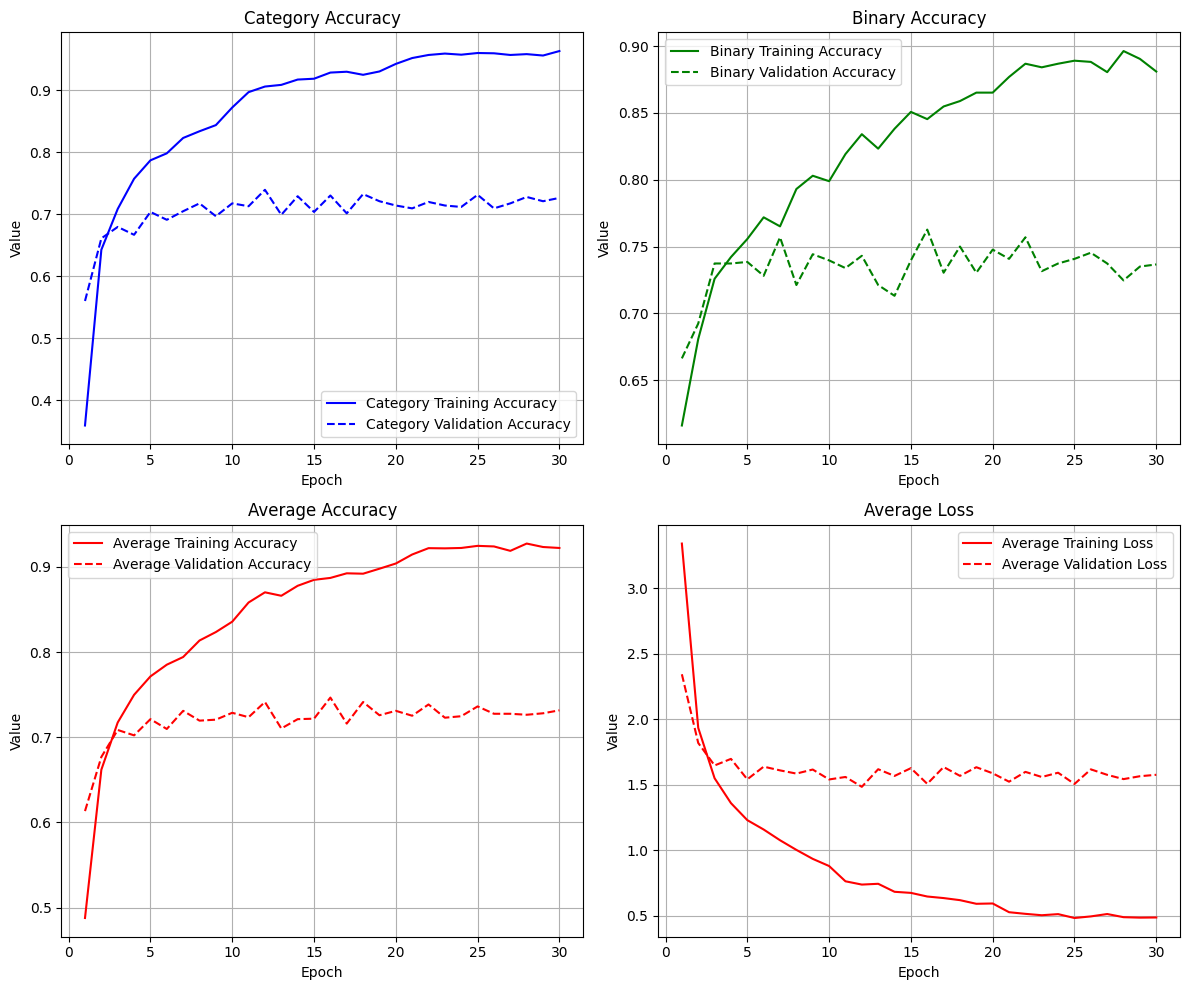

In [86]:
plot_results(m_history['small_head_no_reg'])

### Tuning model head architecture

Whilst the validation performance is very good, exceeding that of the previously discussed paper, training results are significantly outperforming validation results which indicates **overfitting**. This indicates the model has sufficient complexity, and may even have **excess complexity**. Therefore I will reduce the width of some of the MLP layers and see if we can achieve comparable results, and possibly less overfitting, with an even simpler model.

But first, let's define a function for building and training models. This function was designed after the fine tuning process had already been completed, and the desired model architecture and hyper-parameter options were already known, in order to make the code less verbose and more readable.

In [13]:
def build_and_train_model(model_name=None, dropout=0, n_epochs=30,
                          early_stopping_patience=5,
                          include_additional_layer=False,
                          use_early_stopping=False, save_model_weights=False,
                          scaling_factor=1.0, weights_path=None,
                          import_weights=False, use_lr_scheduler=True,
                          lr_schedule=None, val_data_provided=True):
    """Model name needed if saving model weights"""
    #import function to prepare images for model input
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

    #define the input layer
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    #preprocess the input images
    x = preprocess_input(inputs)

    #use the base model to extract features
    x = base_model(inputs, training=False)

    #utilize global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)

    if include_additional_layer:
      x = layers.Dense(2048, activation='relu')(x)
      x = layers.Dropout(dropout)(x)

    x = layers.Dense(int(1024*scaling_factor), activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    #output layer for the categorical classification task
    cat_x = layers.Dense(int(256*scaling_factor), activation='relu')(x)
    cat_x = layers.Dropout(dropout)(cat_x)

    category_output = layers.Dense(40, activation='softmax', name='category_output')(cat_x)

    #output layer for the binary classification task
    bin_x = layers.Dense(int(128*scaling_factor), activation='relu')(x)
    bin_x = layers.Dropout(dropout)(bin_x)

    bin_x = layers.Dense(int(16*scaling_factor), activation='relu')(bin_x)
    bin_x = layers.Dropout(0.5 * dropout)(bin_x)

    binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(bin_x)

    #define the model with two outputs
    model = models.Model(inputs=inputs, outputs=[category_output, binary_output])

    if import_weights:
      model.load_weights(weights_path)

    optimizer = tf.keras.optimizers.Adam() if use_lr_scheduler else tf.keras.optimizers.Adam(lr_schedule)

    #compile the model with combined loss
    model.compile(optimizer=optimizer,
                  loss={'category_output': 'categorical_crossentropy',
                        'binary_output': 'binary_crossentropy'},
                  loss_weights={'category_output': 1.0, 'binary_output': 1.0},
                  metrics={'category_output': 'accuracy',
                          'binary_output': 'accuracy'})

    #define callbacks
    callbacks = [lr_scheduler] if use_lr_scheduler else []

    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True
        )
        callbacks.append(early_stopping)

    if save_model_weights:
        checkpoint_all = tf.keras.callbacks.ModelCheckpoint(
            f'/content/drive/My Drive/Colab Notebooks/model_files/{model_name}_epoch_{{epoch:02d}}.keras',
            save_freq='epoch'
        )
        callbacks.append(checkpoint_all)

    #train the model
    if val_data_provided:
        history = model.fit(train_generator,
                        epochs=n_epochs,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_data=validation_generator,
                        validation_steps=steps_per_epoch_val,
                        callbacks=callbacks)
    else:
        history = model.fit(train_generator,
                        epochs=n_epochs,
                        steps_per_epoch=steps_per_epoch_train,
                        callbacks=callbacks)

    return history

Changes:
* halved width of first dense layer
* halved width of intermediate categorical layer
* halved width of both intermediate binary layers

Justification: making model head significanlty simpler/smaller to see if evaluation losses are impacted (because overfitting was observed above)

In [ ]:
m_history['tiny_head_no_reg'] = build_and_train_model(scaling_factor=0.5)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 94s 900ms/step - binary_output_accuracy: 0.5886 - category_output_accuracy: 0.1674 - loss: 4.0729 - val_binary_output_accuracy: 0.6786 - val_category_output_accuracy: 0.4942 - val_loss: 2.8620 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - binary_output_accuracy: 0.6760 - category_output_accuracy: 0.5331 - loss: 2.5878 - val_binary_output_accuracy: 0.7304 - val_category_output_accuracy: 0.6313 - val_loss: 2.0091 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 411ms/step - binary_output_accuracy: 0.7071 - category_output_accuracy: 0.6438 - loss: 1.9382 - val_binary_output_accuracy: 0.7166 - val_category_output_accuracy: 0.6694 - val_loss: 1.7960 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 410ms/step - binary_output_accuracy: 0.7198 - category_output_accuracy: 0.7028 - loss: 1.6072 - val_binary_output_accuracy: 0.7419 - val_category_output_accuracy: 0.6694 - val_loss:

Note: The majority of model training plots in this report start the x axis at 0, I did not notice this error until after I had deleted the pickle file. Only the first model has been retrained to fix the plot.

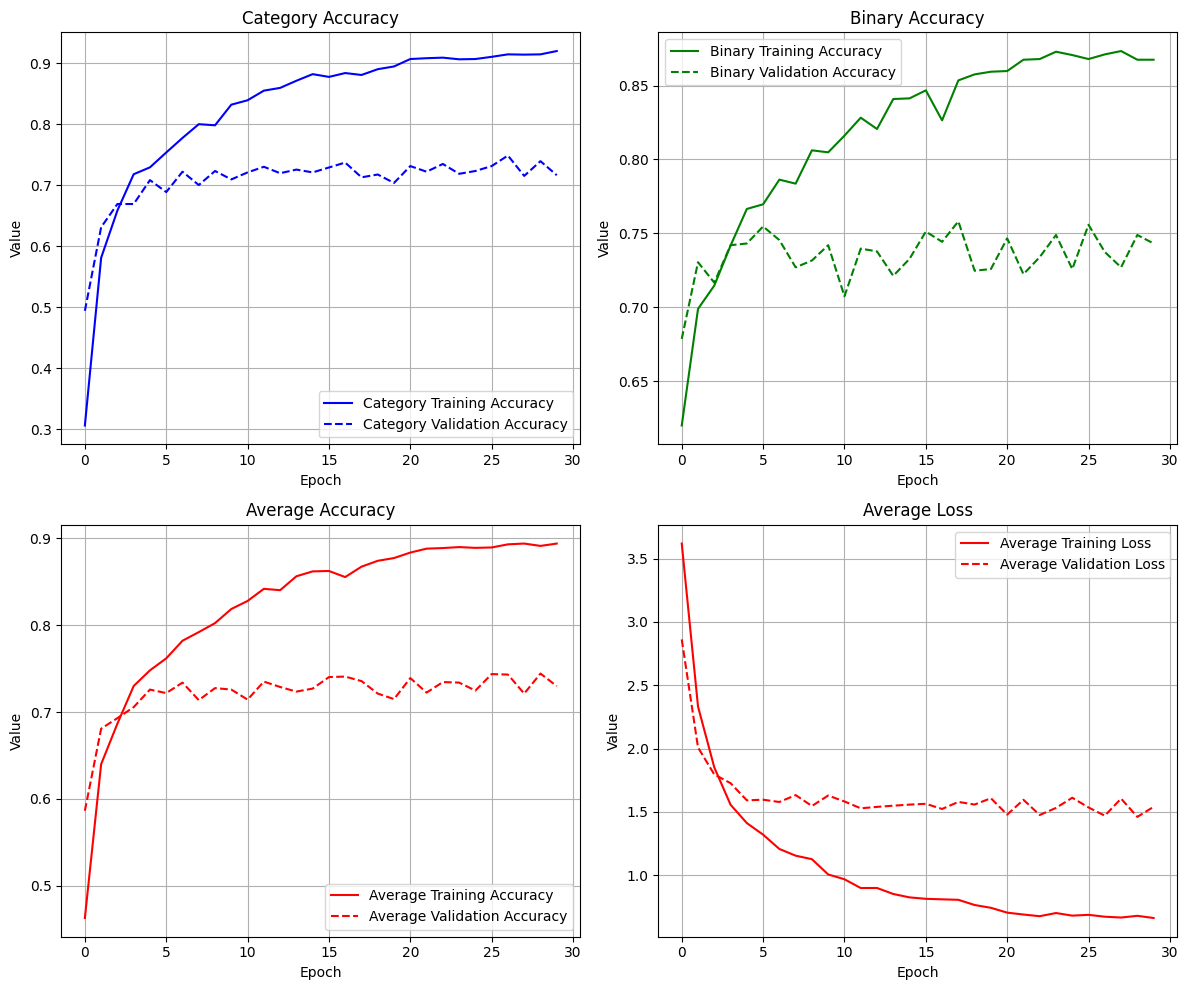

In [ ]:
plot_results(m_history['tiny_head_no_reg'])

Both models have similar performance, but the **tiny head model appears to be better** due to:

* higher validation accuracy
* lower validation losses
* smoother loss curve indicating more stable training process

However, **a conclusion should not yet be made**, as **regularisation can be beneficial** to model performance, therefore some extra model capacity can be adventagious. In other words, the **small headed model may cope better with regularisation** resulting in a better model.

To be sure, and to further **explore the relationship between head size and validation performance** before moving onto hyper-parameter optimisation, I will try one more head architecture with a significantly larger head, but I will retain the smaller intermediate non-common layers, in case it was this feature of the tiny head which allowed it to perform better.

Changes:
* Increased head depth with new 2048 neuron layer at beginning of common branch

Justification: making model head significantly larger/more complex to explore the trend between head size and validation performance

In [ ]:
m_history['small_tiny_head_no_reg'] = build_and_train_model(
                                              include_additional_layer=True,
                                              scaling_factor=0.5)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 92s 890ms/step - binary_output_accuracy: 0.6332 - category_output_accuracy: 0.2918 - loss: 3.7112 - val_binary_output_accuracy: 0.7005 - val_category_output_accuracy: 0.6118 - val_loss: 2.0401 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 417ms/step - binary_output_accuracy: 0.6989 - category_output_accuracy: 0.6722 - loss: 1.8974 - val_binary_output_accuracy: 0.7339 - val_category_output_accuracy: 0.6728 - val_loss: 1.7435 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 413ms/step - binary_output_accuracy: 0.7267 - category_output_accuracy: 0.7097 - loss: 1.5563 - val_binary_output_accuracy: 0.6959 - val_category_output_accuracy: 0.6659 - val_loss: 1.7302 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 408ms/step - binary_output_accuracy: 0.7529 - category_output_accuracy: 0.7812 - loss: 1.2832 - val_binary_output_accuracy: 0.7281 - val_category_output_accuracy: 0.6717 - val_loss:

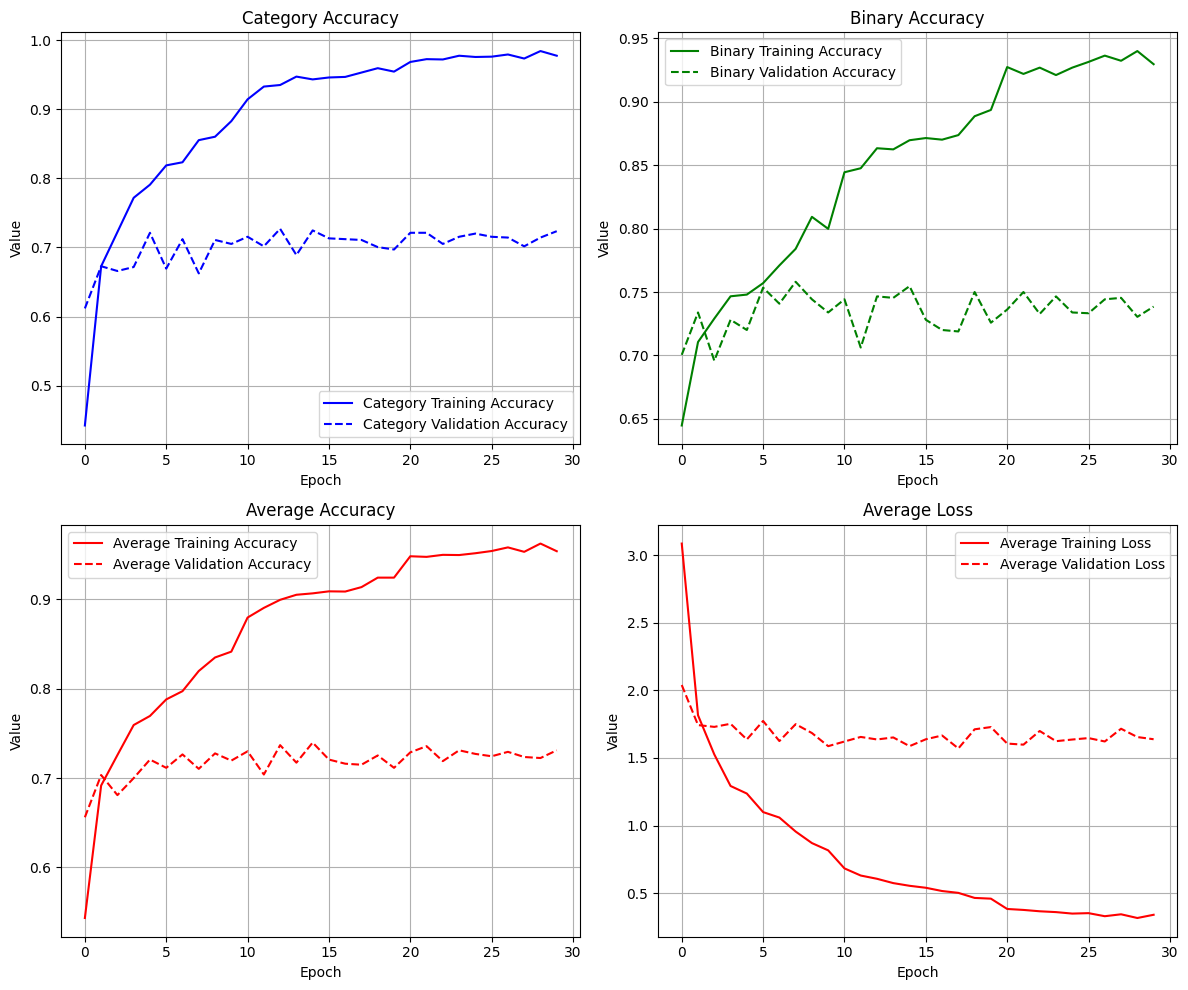

In [ ]:
plot_results(m_history['small_tiny_head_no_reg'])

This model achieved **lower categorical accuracies** and the **loss curve is not as smooth**, with **higher losses**, supporting the case that the tiny head is the best model head architecture. It also displays **more extreme overfitting** on the training data with training loss well below 0.5 despite the worse validation losses.

### Hyper-parameter tuning (introducing regularisation)

Regularization Options:

* L2 Regularization: This method penalizes the model based on the sum of the squares of the model weights, encouraging the model to reduce weights toward zero. This helps in controlling the complexity of the model and preventing it from relying too heavily on any single weight, which can lead to overfitting.

* Dropout: Dropout randomly deactivates a proportion of neurons during training, preventing the model from becoming overly dependent on specific neurons or features. This method generally **leads to better generalization by promoting a more diverse and robust feature representation**. Dropout is often preferred for regularization because it helps enforce a more robust training process, leveraging a broader set of features for making predictions.

* Early stopping: Early stopping will be used less as a regularisation method, where training would be stopped before the model has a chance to converge, and more as a method of **saving on computation** if evaluation performance stalls

Implementation Plan:

* Dropout Value: Common dropout values range from 0.2 to 0.5. I will start with a dropout value of 0.4, which provides a **balanced initial point**. This allows **flexibility to adjust the value up or down** depending on whether the model is showing signs of **underfitting or overfitting** during training i.e. random search

* Specific Case in Binary Output Layer: In the final transition to the binary output layer, where only 8 neurons feed into the final single neuron, a **high dropout value could significantly limit the information available for binary predictions**. To prevent this, I will apply a dropout multiplier of 0.5 in this layer, reducing the dropout rate and ensuring that sufficient information is retained for making accurate binary predictions.

* Epochs: Because I am **implementing early stopping**, I am also **increasing number of epochs** out to 50 from here on, as long as the models are achieving improving validation losses, they will be allowed to run, the theory here is that the **number of epochs should not be restrictive**.

In [ ]:
m_history['tiny_head_dropout_0.4'] = build_and_train_model(
                                        dropout=0.4,
                                        n_epochs=50,
                                        use_early_stopping=True,
                                        scaling_factor=0.5)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 779ms/step - binary_output_accuracy: 0.5399 - category_output_accuracy: 0.0378 - loss: 4.8314 - val_binary_output_accuracy: 0.6866 - val_category_output_accuracy: 0.3088 - val_loss: 3.8813 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 436ms/step - binary_output_accuracy: 0.6047 - category_output_accuracy: 0.1634 - loss: 4.0295 - val_binary_output_accuracy: 0.6820 - val_category_output_accuracy: 0.4090 - val_loss: 3.4132 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - binary_output_accuracy: 0.6101 - category_output_accuracy: 0.2643 - loss: 3.6487 - val_binary_output_accuracy: 0.6682 - val_category_output_accuracy: 0.5092 - val_loss: 2.9784 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 412ms/step - binary_output_accuracy: 0.6588 - category_output_accuracy: 0.3350 - loss: 3.3243 - val_binary_output_accuracy: 0.7189 - val_category_output_accuracy: 0.5403 - val_loss:

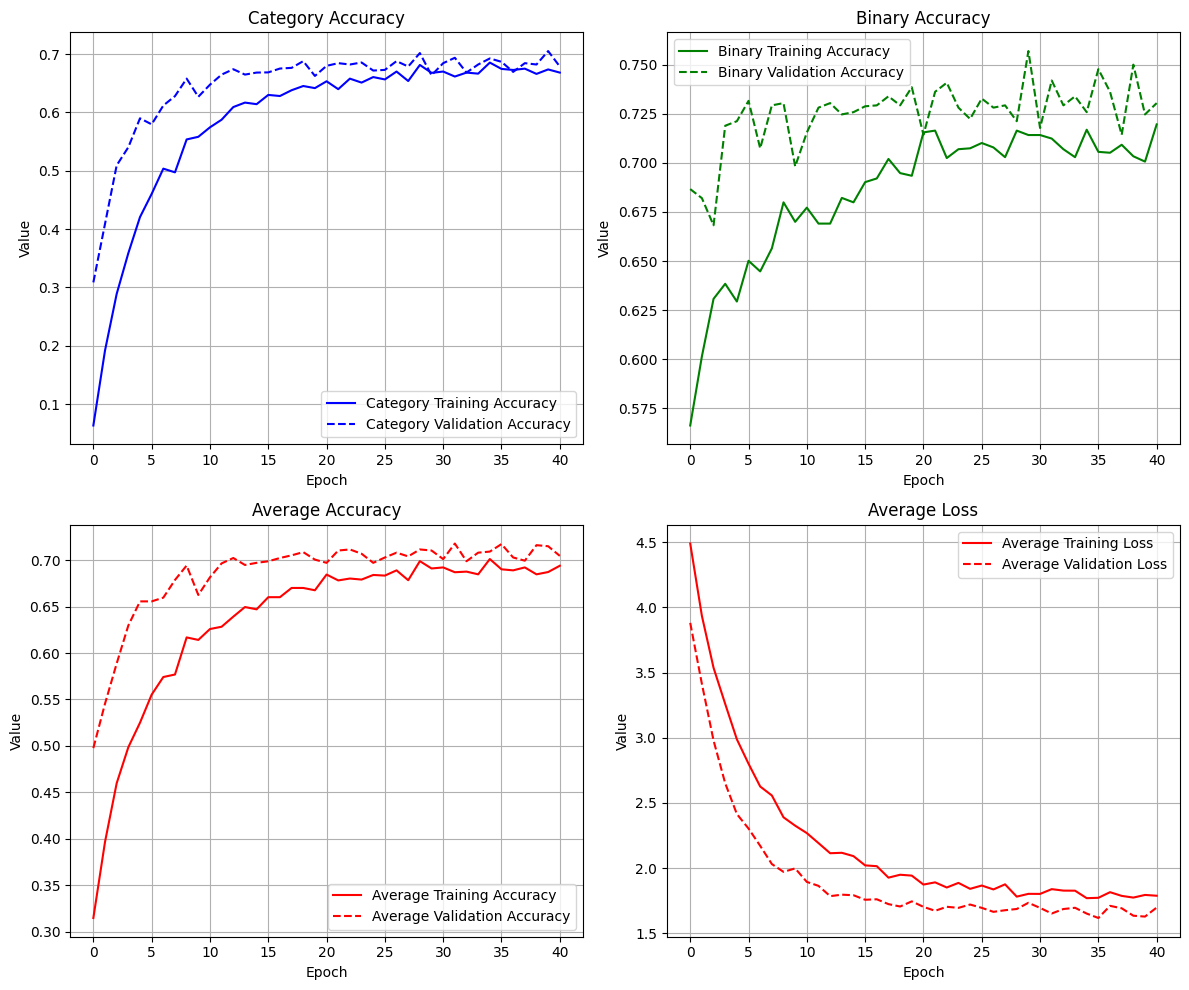

In [ ]:
plot_results(m_history['tiny_head_dropout_0.4'])

Whilst the training process was extremely stable, reaching the best validation loss at epoch 35, **validation loss is higher** than before implementing dropout. It seems the model is well regularised (val performance is higher due to lack of regularisation via dropout and augmentation) however, **possibly due to it's relative simplicity, it hasn't handled the regularisation very well** with validation loss deteriorating. Of particular note is the deterioration in category accuracy. Thus I will try our very similarly performing but more complex small headed model. Later I will also try tuning the dropout on the above model.

In [ ]:
m_history['small_head_dropout_0.4'] = build_and_train_model(
                                        dropout=0.4,
                                        n_epochs=50,
                                        use_early_stopping=True)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 875ms/step - binary_output_accuracy: 0.5717 - category_output_accuracy: 0.0751 - loss: 4.5961 - val_binary_output_accuracy: 0.6797 - val_category_output_accuracy: 0.4597 - val_loss: 3.3560 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 431ms/step - binary_output_accuracy: 0.6123 - category_output_accuracy: 0.2699 - loss: 3.5917 - val_binary_output_accuracy: 0.7120 - val_category_output_accuracy: 0.5553 - val_loss: 2.6144 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - binary_output_accuracy: 0.6286 - category_output_accuracy: 0.4267 - loss: 3.0150 - val_binary_output_accuracy: 0.7454 - val_category_output_accuracy: 0.6210 - val_loss: 2.1778 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 411ms/step - binary_output_accuracy: 0.6566 - category_output_accuracy: 0.4939 - loss: 2.6004 - val_binary_output_accuracy: 0.7177 - val_category_output_accuracy: 0.6336 - val_loss:

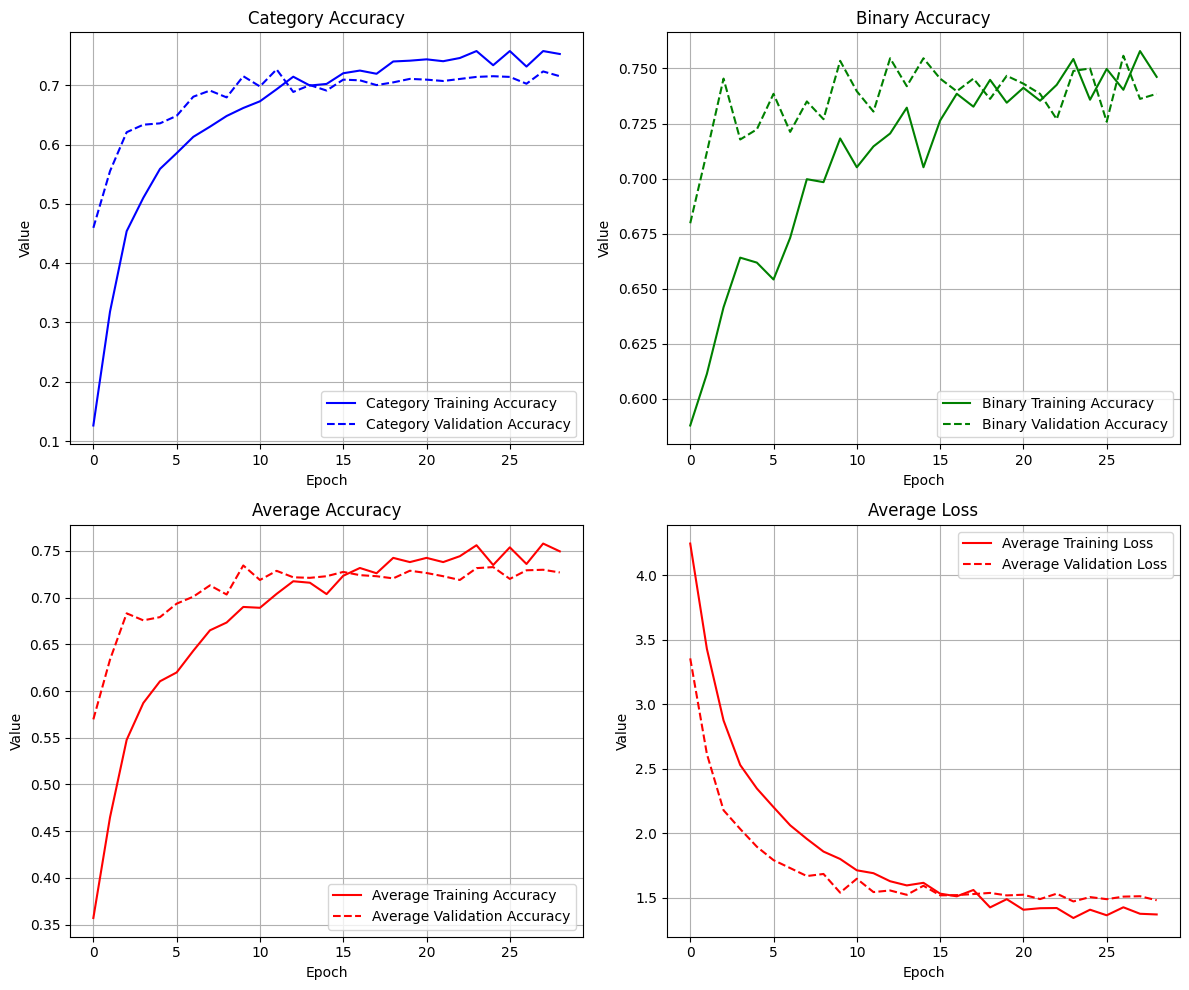

In [ ]:
plot_results(m_history['small_head_dropout_0.4'])

Evidently, from the **higher validation accuracies and lower validation loss**, the **small head model handled dropout much better**. Considering this potential trend, we will need to **try the even more complex model with dropout** and see if we get even higher validation performance again. If not we will tune dropout on the above models to see if we can improve performance.

In [ ]:
m_history['small_tiny_head_dropout_0.4'] = build_and_train_model(
                                              dropout=0.4,
                                              n_epochs=50,
                                              use_early_stopping=True,
                                              scaling_factor=0.5,
                                              include_additional_layer=True)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 843ms/step - binary_output_accuracy: 0.5540 - category_output_accuracy: 0.0459 - loss: 4.6225 - val_binary_output_accuracy: 0.6682 - val_category_output_accuracy: 0.3041 - val_loss: 3.9589 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 428ms/step - binary_output_accuracy: 0.6155 - category_output_accuracy: 0.1465 - loss: 4.0445 - val_binary_output_accuracy: 0.6924 - val_category_output_accuracy: 0.4827 - val_loss: 3.4395 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - binary_output_accuracy: 0.6139 - category_output_accuracy: 0.2477 - loss: 3.7270 - val_binary_output_accuracy: 0.6912 - val_category_output_accuracy: 0.5115 - val_loss: 3.0106 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 408ms/step - binary_output_accuracy: 0.6058 - category_output_accuracy: 0.3169 - loss: 3.4867 - val_binary_output_accuracy: 0.7224 - val_category_output_accuracy: 0.5576 - val_loss:

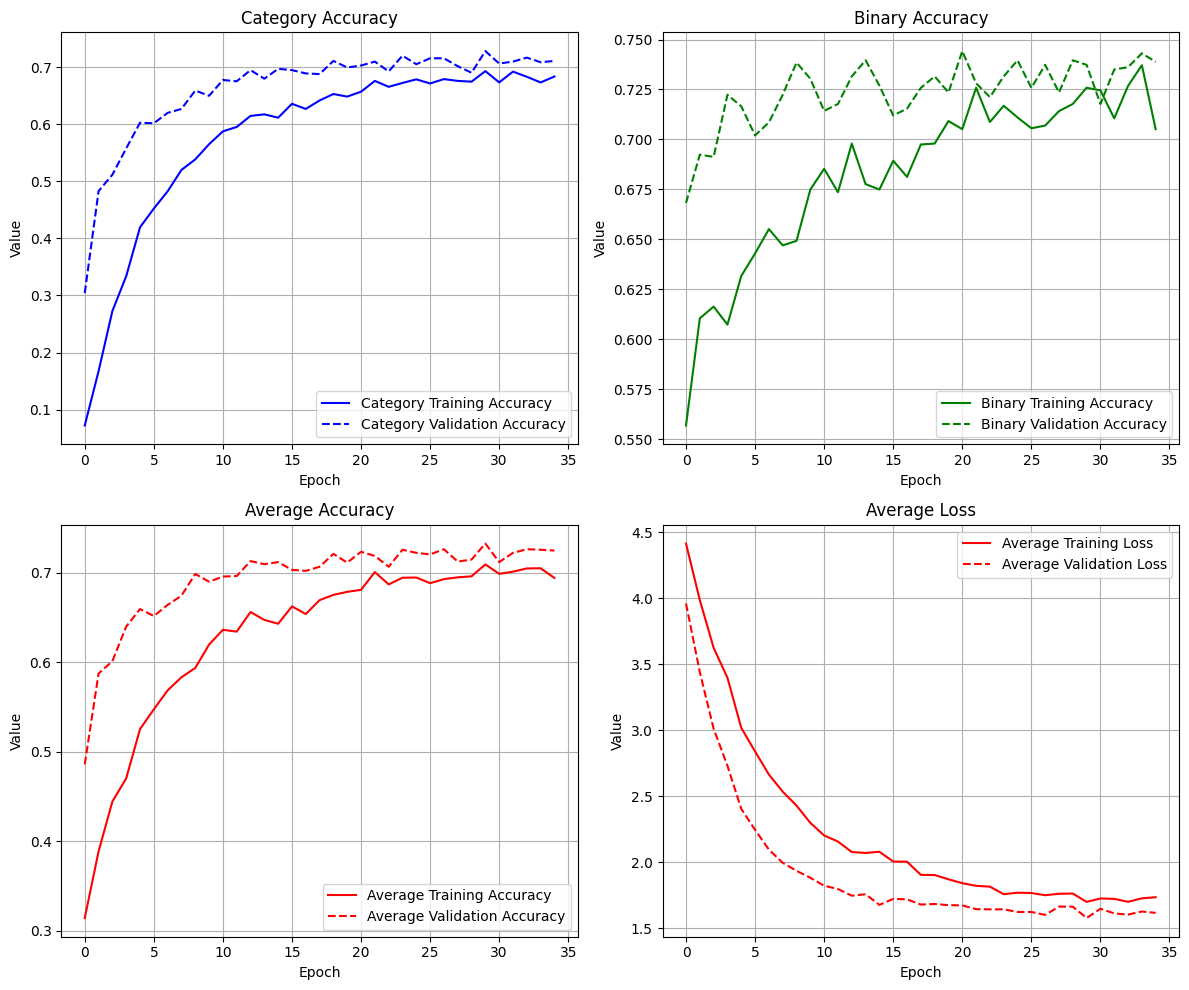

In [ ]:
plot_results(m_history['small_tiny_head_dropout_0.4'])

This model **performed worse than the unregularised version** of the same model, which was the worse of the 3 models to begin with. That debunks any theory that the more complex model with dropout added could outperform the simpler models, i.e. it seems there is a sweet spot between not enough and too much extra model capacity for dropout regularisation to be beneficial to performance.

Let's consider model performances so far

In [ ]:
# Create a list to store the results
results = []

# Iterate over each model history in the dictionary
for model_name, history in m_history.items():
    best_val_loss = min(history.history['val_loss'])
    results.append({'Model': model_name, 'Best Validation Loss': best_val_loss})

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)

                         Model  Best Validation Loss
0            small_head_no_reg              1.511242
1             tiny_head_no_reg              1.461359
2       small_tiny_head_no_reg              1.570689
3        tiny_head_dropout_0.4              1.603258
4       small_head_dropout_0.4              1.470332
5  small_tiny_head_dropout_0.4              1.578326


So far the **best performing models are tiny head with no regularisation and small head with 0.4 dropout**. Let's **tune dropout** and **see if the validation performance could be improved** by either adding minimal dropout to the tiny head model or tuning the dropout on the small head model.

In [ ]:
m_history['tiny_head_dropout_0.1'] = build_and_train_model(
                                              dropout=0.1,
                                              n_epochs=50,
                                              use_early_stopping=True,
                                              save_model_weights=True,
                                              model_name='model_tiny_0.1',
                                              scaling_factor=0.5)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 835ms/step - binary_output_accuracy: 0.5937 - category_output_accuracy: 0.1164 - loss: 4.2650 - val_binary_output_accuracy: 0.6889 - val_category_output_accuracy: 0.4217 - val_loss: 3.2546 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 483ms/step - binary_output_accuracy: 0.6550 - category_output_accuracy: 0.4283 - loss: 3.1241 - val_binary_output_accuracy: 0.7166 - val_category_output_accuracy: 0.5703 - val_loss: 2.4096 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - binary_output_accuracy: 0.6839 - category_output_accuracy: 0.5574 - loss: 2.4209 - val_binary_output_accuracy: 0.6982 - val_category_output_accuracy: 0.6141 - val_loss: 2.0525 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 439ms/step - binary_output_accuracy: 0.7087 - category_output_accuracy: 0.5987 - loss: 2.0700 - val_binary_output_accuracy: 0.7085 - val_category_output_accuracy: 0.6555 - val_loss:

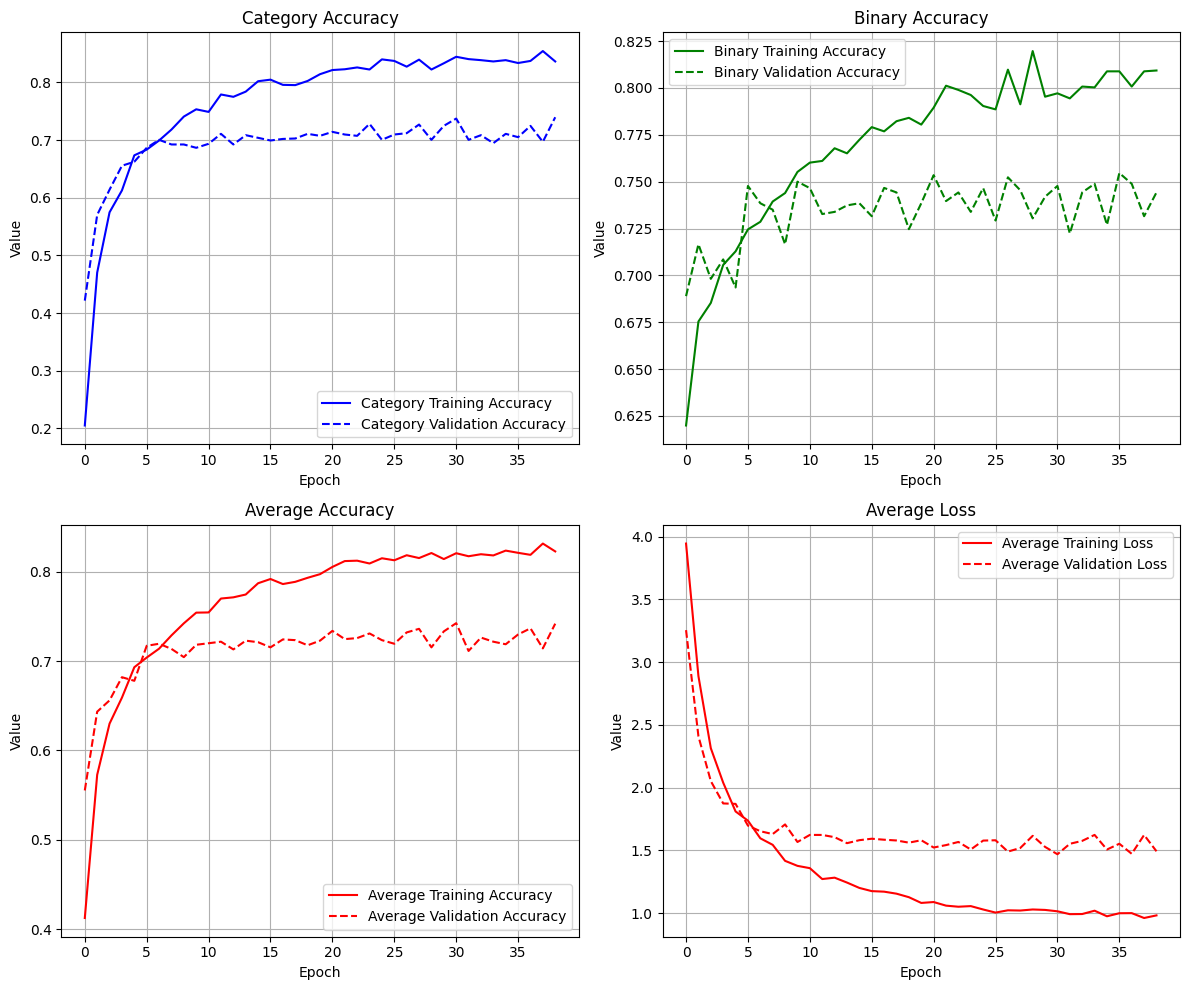

In [ ]:
plot_results(m_history['tiny_head_dropout_0.1'])

* **low validation loss** - 1.45
* **validation losses volatile** at higher epochs where the best val loss was achieved - **may generalise poorly**/could be indication of overfitting validation set
* keeping in mind that a smoother curve (if achieved) could be an indication that the small model with higher dropout will generalise better

Let's see how the tiny model handles more regularisation:

* **patience increased to prevent** volatile validation losses causing **premature stopping**

This needs to be considered when analysing the results of the below model, i.e. extra awareness regarding potential overfitting on validation images. Perhaps it **could have been better to also use image augmentation** to increase the size of the **validation data** set to reduce the potential for this to happen

In [ ]:
m_history['tiny_head_dropout_0.2'] = build_and_train_model(
                                              dropout=0.2,
                                              n_epochs=50,
                                              patience=10,
                                              use_early_stopping=True,
                                              save_model_weights=True,
                                              model_name='model_tiny_0.2',
                                              scaling_factor=0.5)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 823ms/step - binary_output_accuracy: 0.5844 - category_output_accuracy: 0.1036 - loss: 4.3237 - val_binary_output_accuracy: 0.6555 - val_category_output_accuracy: 0.3975 - val_loss: 3.3518 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 486ms/step - binary_output_accuracy: 0.6007 - category_output_accuracy: 0.3646 - loss: 3.3761 - val_binary_output_accuracy: 0.7177 - val_category_output_accuracy: 0.5530 - val_loss: 2.5454 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - binary_output_accuracy: 0.6514 - category_output_accuracy: 0.4968 - loss: 2.6967 - val_binary_output_accuracy: 0.6901 - val_category_output_accuracy: 0.5876 - val_loss: 2.2188 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 439ms/step - binary_output_accuracy: 0.6688 - category_output_accuracy: 0.5558 - loss: 2.3870 - val_binary_output_accuracy: 0.7431 - val_category_output_accuracy: 0.6452 - val_loss:

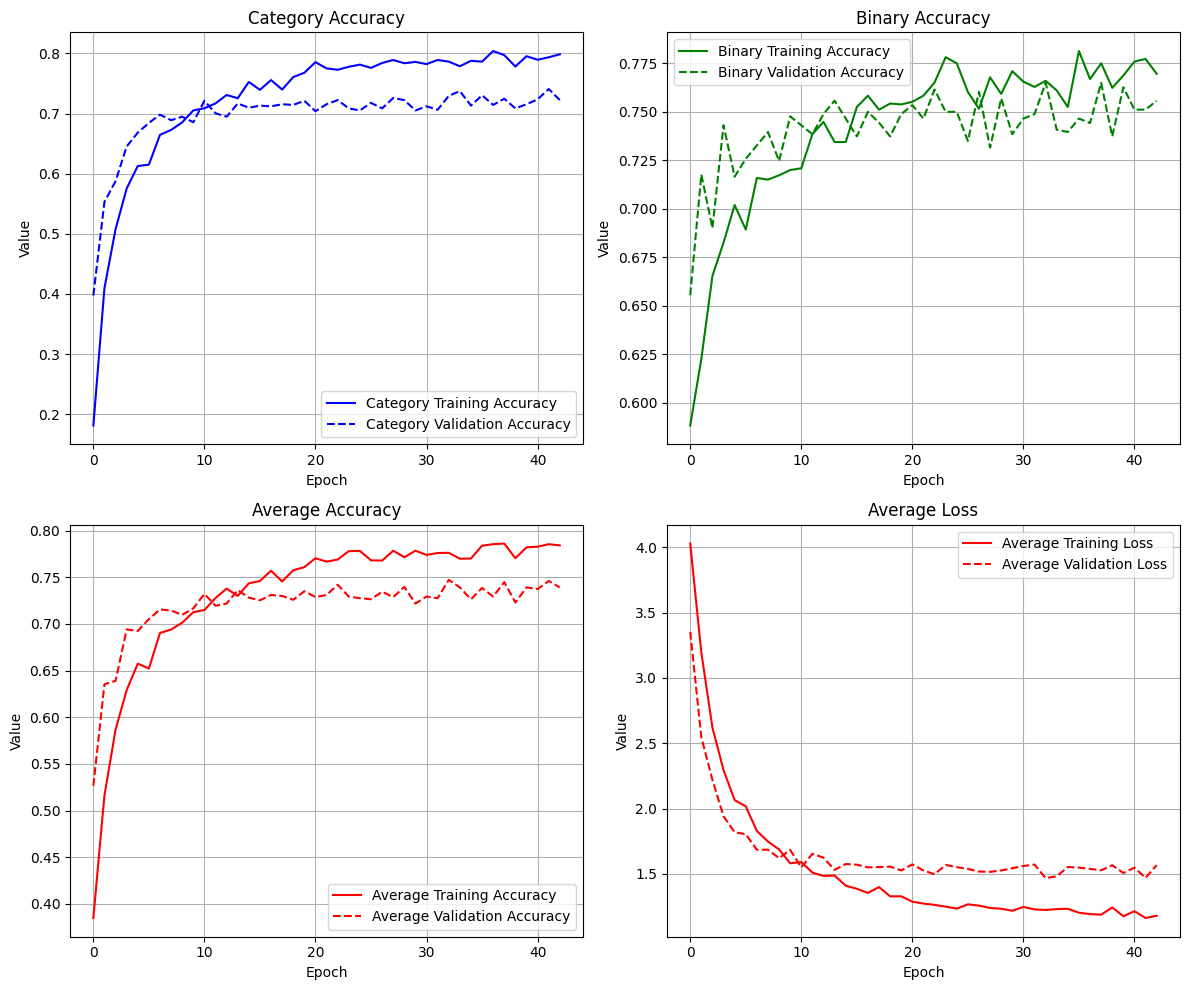

In [ ]:
plot_results(m_history['tiny_head_dropout_0.2'])

* low losses achieved at higher epochs with volatile loss curve
* low losses likely the result of random overfitting on the validation image set
* **could benefit from additional regularisation**

In [ ]:
m_history['tiny_head_dropout_0.3'] = build_and_train_model(
                                              dropout=0.3,
                                              n_epochs=50,
                                              use_early_stopping=True,
                                              scaling_factor=0.5)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 780ms/step - binary_output_accuracy: 0.5703 - category_output_accuracy: 0.0746 - loss: 4.4877 - val_binary_output_accuracy: 0.6728 - val_category_output_accuracy: 0.3825 - val_loss: 3.5957 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 431ms/step - binary_output_accuracy: 0.5976 - category_output_accuracy: 0.2492 - loss: 3.7273 - val_binary_output_accuracy: 0.6924 - val_category_output_accuracy: 0.5115 - val_loss: 2.9363 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - binary_output_accuracy: 0.6161 - category_output_accuracy: 0.3735 - loss: 3.2245 - val_binary_output_accuracy: 0.7154 - val_category_output_accuracy: 0.5622 - val_loss: 2.4646 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - binary_output_accuracy: 0.6329 - category_output_accuracy: 0.4553 - loss: 2.8254 - val_binary_output_accuracy: 0.7108 - val_category_output_accuracy: 0.6187 - val_loss:

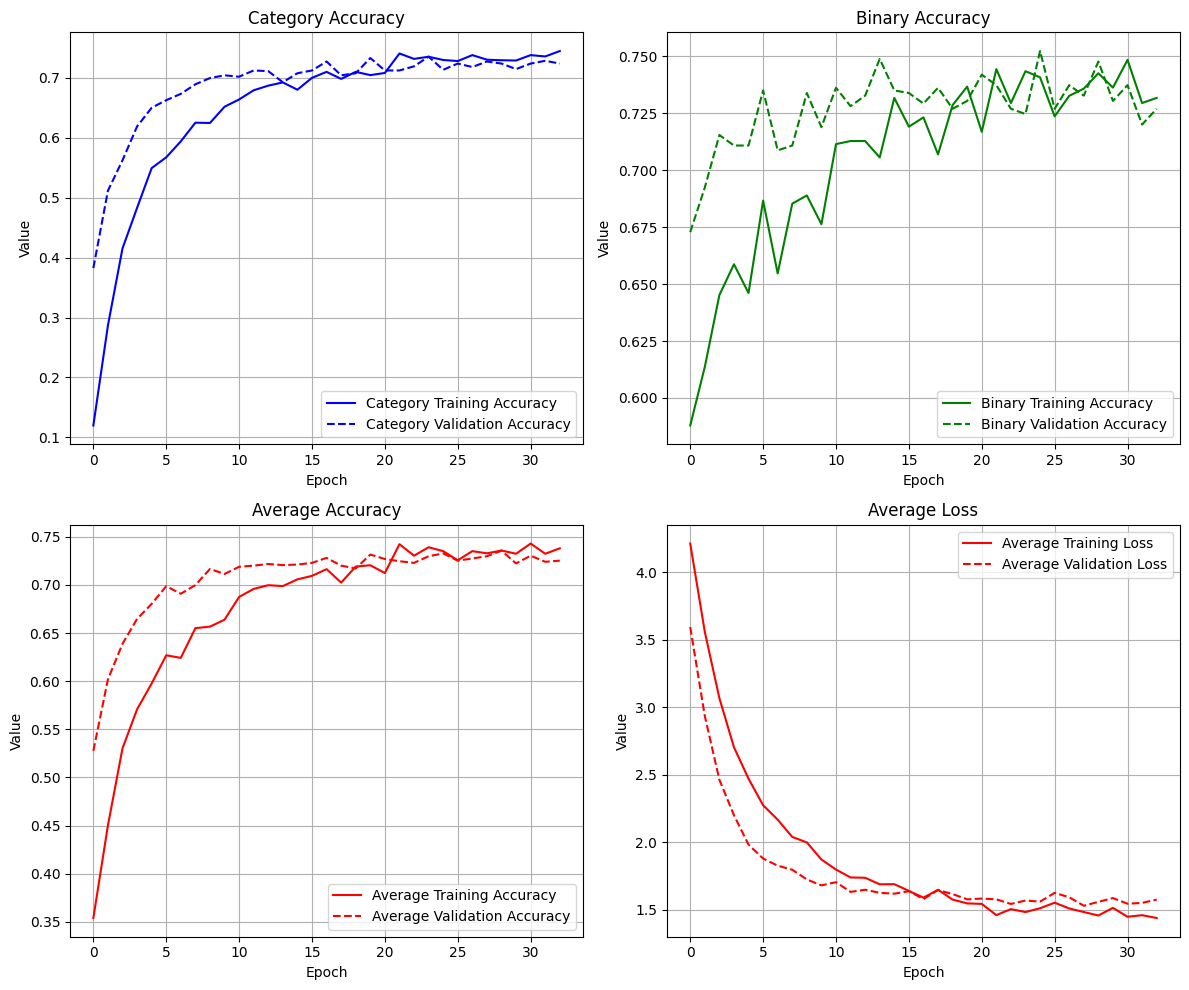

In [ ]:
plot_results(m_history['tiny_head_dropout_0.3'])

* Model appears **well regularised** with similar training and validation performance,
* **Higher regularisation during training has begun to erode validation performance** resulting in higher validation losses.
* Smooth learning curve but inferior losses

Time to try tuning dropout on the small headed model, this model improved when dropout was added, but it was **not clear whether the model would further benefit from more or less dropout** based on the learning curve, so I will try +- 0.1 from the original 0.4 setting, to be sure.

In [ ]:
m_history['small_head_dropout_0.5'] = build_and_train_model(
                                              dropout=0.5,
                                              n_epochs=50,
                                              use_early_stopping=True)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 775ms/step - binary_output_accuracy: 0.5301 - category_output_accuracy: 0.0490 - loss: 4.9767 - val_binary_output_accuracy: 0.6555 - val_category_output_accuracy: 0.3571 - val_loss: 3.8058 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - binary_output_accuracy: 0.5752 - category_output_accuracy: 0.1691 - loss: 3.9850 - val_binary_output_accuracy: 0.6740 - val_category_output_accuracy: 0.4735 - val_loss: 3.2461 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - binary_output_accuracy: 0.6061 - category_output_accuracy: 0.2968 - loss: 3.5435 - val_binary_output_accuracy: 0.7120 - val_category_output_accuracy: 0.5530 - val_loss: 2.8103 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 417ms/step - binary_output_accuracy: 0.6347 - category_output_accuracy: 0.4063 - loss: 3.0756 - val_binary_output_accuracy: 0.7258 - val_category_output_accuracy: 0.6152 - val_loss:

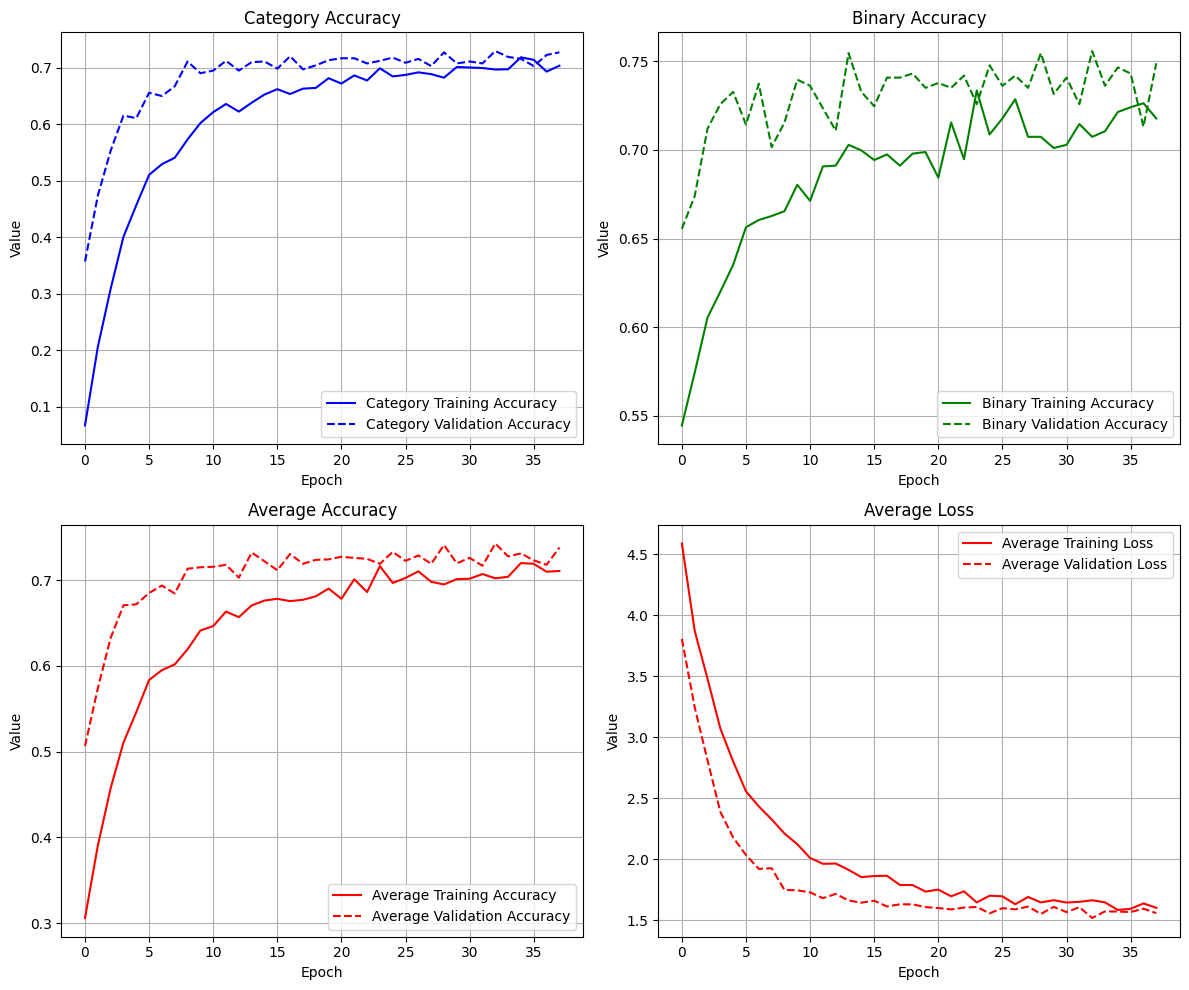

In [ ]:
plot_results(m_history['small_head_dropout_0.5'])

* smooth learning curve
* no overfitting or underfitting
* **validation losses not as good** as other models

Let's see if the small headed model benefits when dropout is reduced:

In [ ]:
m_history['small_head_dropout_0.3'] = build_and_train_model(
                                              dropout=0.3,
                                              n_epochs=50,
                                              use_early_stopping=True,
                                              save_model_weights=True,
                                              model_name='model_small_0.3')

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - binary_output_accuracy: 0.5741 - category_output_accuracy: 0.1028 - loss: 4.4247 - val_binary_output_accuracy: 0.7031 - val_category_output_accuracy: 0.5056 - val_loss: 3.0866 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 57s 817ms/step - binary_output_accuracy: 0.6210 - category_output_accuracy: 0.3982 - loss: 3.1886 - val_binary_output_accuracy: 0.7235 - val_category_output_accuracy: 0.6002 - val_loss: 2.2466 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 699ms/step - binary_output_accuracy: 0.6625 - category_output_accuracy: 0.5342 - loss: 2.5414 - val_binary_output_accuracy: 0.7108 - val_category_output_accuracy: 0.6475 - val_loss: 1.9510 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 705ms/step - binary_output_accuracy: 0.6763 - category_output_accuracy: 0.5786 - loss: 2.1854 - val_binary_output_accuracy: 0.7270 - val_category_output_accuracy: 0.6590 - val_loss: 1

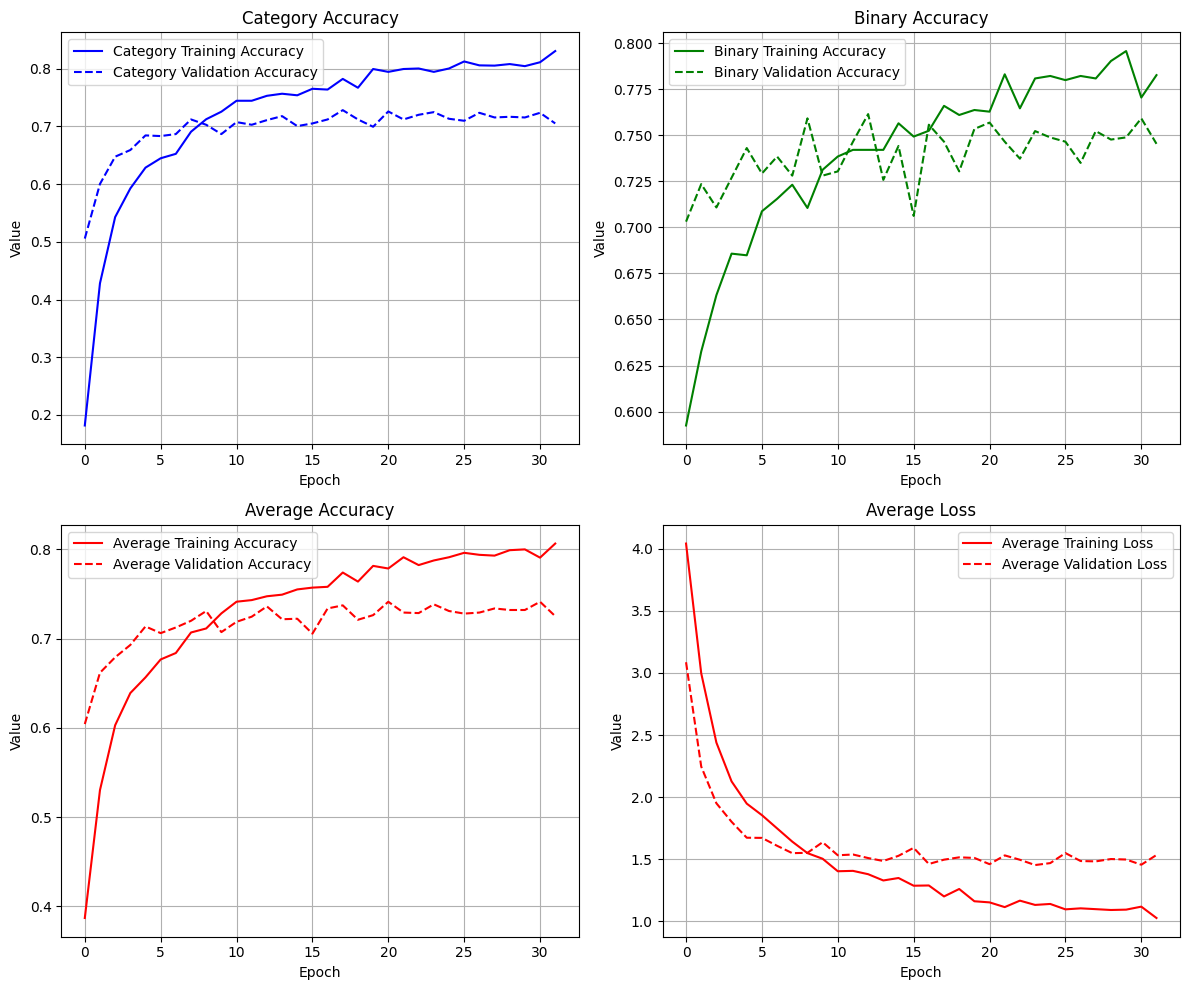

In [ ]:
plot_results(m_history['small_head_dropout_0.3'])

This would appear to be the best looking learning curves so far:
* Only extremely mild/**no overfitting on training data** which seems to be benefitial for validation performance
* The **curve is relatively smooth**, indicating that the **training process was relatively stable**, and the lowest validation loss of 1.45 was achieved in epoch 24. Although the model is performing higher on training data despite the data augmentation and dropout, early stopping has prevented any excessive overfitting on the training data.
* Upward and downward movements in training accuracy generally appear to correlate with the same for validation accuracy, indicating that the model is generalising well to the validation data, and high validation performance is the result of the model accurately modelling the features in the images, as opposed to being the result of random overfitting.

Time to have a look at the scoreboard:

In [ ]:
#list to store the results
results = []

#iterate over each model history in the dictionary
for model_name, history in m_history.items():
    best_val_loss = min(history.history['val_loss'])
    results.append({'Model': model_name, 'Best Validation Loss': best_val_loss})

#convert the results list to a DataFrame
df_results = pd.DataFrame(results)

#sort the DataFrame by "Best Validation Loss" in ascending order
df_results = df_results.sort_values(by='Best Validation Loss', ascending=True)

#display the DataFrame
print(df_results)

                          Model  Best Validation Loss
9        small_head_dropout_0.3              1.453742
1              tiny_head_no_reg              1.461359
7         tiny_head_dropout_0.2              1.467516
6         tiny_head_dropout_0.1              1.469762
4        small_head_dropout_0.4              1.470332
0             small_head_no_reg              1.511242
8        small_head_dropout_0.5              1.517280
10        tiny_head_dropout_0.3              1.531180
2        small_tiny_head_no_reg              1.570689
5   small_tiny_head_dropout_0.4              1.578326
3         tiny_head_dropout_0.4              1.616308


In [27]:
m_history['small_head_dropout_0.2'] = build_and_train_model(
                                              dropout=0.2,
                                              n_epochs=50,
                                              use_early_stopping=True,
                                              save_model_weights=True,
                                              model_name='model_small_0.2')

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 92s 845ms/step - binary_output_accuracy: 0.5749 - category_output_accuracy: 0.1406 - loss: 4.2487 - val_binary_output_accuracy: 0.6897 - val_category_output_accuracy: 0.5290 - val_loss: 2.7390 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 567ms/step - binary_output_accuracy: 0.6575 - category_output_accuracy: 0.4718 - loss: 2.7756 - val_binary_output_accuracy: 0.7212 - val_category_output_accuracy: 0.6394 - val_loss: 1.9986 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - binary_output_accuracy: 0.6709 - category_output_accuracy: 0.5841 - loss: 2.1255 - val_binary_output_accuracy: 0.6959 - val_category_output_accuracy: 0.6636 - val_loss: 1.7919 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - binary_output_accuracy: 0.7097 - category_output_accuracy: 0.6578 - loss: 1.8056 - val_binary_output_accuracy: 0.7200 - val_category_output_accuracy: 0.6855 - val_loss:

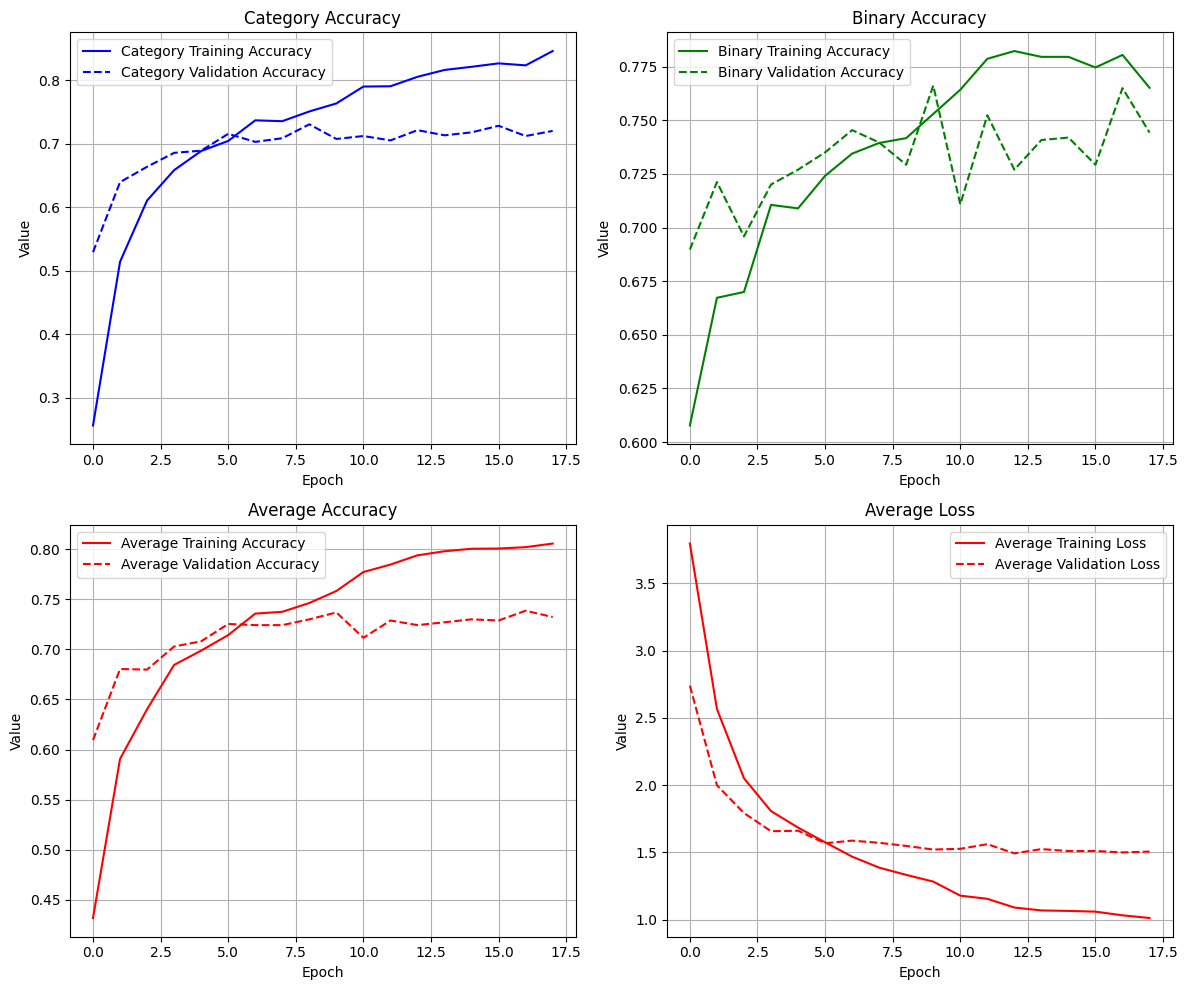

In [37]:
plot_results(m_history['small_head_dropout_0.2'])

Validation accuracies and losses plateaued whilst the model's performance on the training data continued improving despite dropout and image augmentation, suggesting this model was beginning to overfit on the training data. It was stopped quite early by early stopping when it failed to improve on a validation loss of 1.492, which would not place it within the top 5 models trained so far. It seems 0.2 dropout is not sufficient regularisation for the small model head to prevent overfitted from detracting from model performance on the validation data. Therefore it is not worth trialing 0.1 dropout for this head, and it is time to move on to comparing the models.

Visualise the loss curves of the best performing models together for comparison

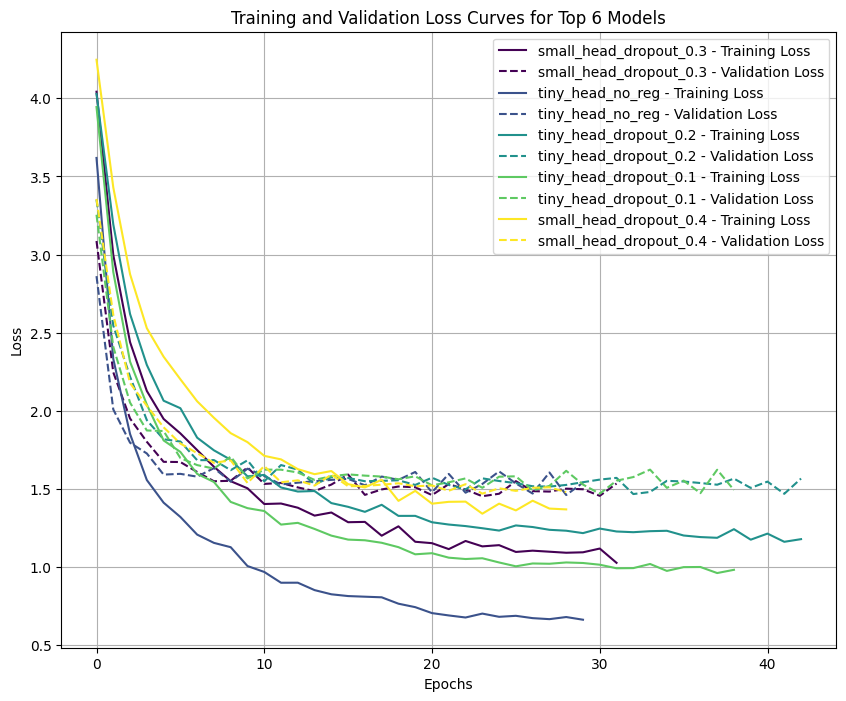

In [ ]:
#sort dataframe by "Best Validation Loss" and get the top 5 models
top_5_models = df_results.sort_values(by='Best Validation Loss', ascending=True).head(5)['Model'].tolist()

#colour cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(top_5_models)))

#plot the loss curves for each of the top 6 models
plt.figure(figsize=(10, 8))
for i, model_name in enumerate(top_5_models):
    history = m_history[model_name].history
    plt.plot(history['loss'], color=colors[i], label=f'{model_name} - Training Loss', linestyle='-')
    plt.plot(history['val_loss'], color=colors[i], label=f'{model_name} - Validation Loss', linestyle='--')

#add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Top 6 Models')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Zoom it in to get a clearer look at the differences in validation loss curves

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

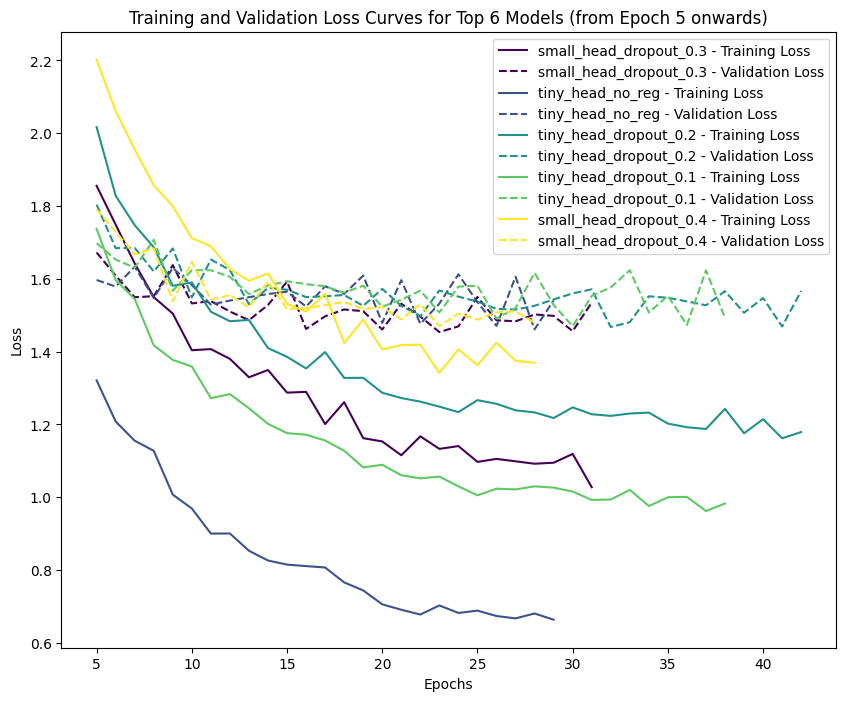

In [ ]:
#plot the loss curves for each of the top 6 models
plt.figure(figsize=(10, 8))
for i, model_name in enumerate(top_5_models):
    history = m_history[model_name].history
    epochs = range(5, len(history['loss']))  #start from epoch 5

    #slice the loss and val_loss from epoch 5 onwards
    plt.plot(epochs, history['loss'][5:], color=colors[i], label=f'{model_name} - Training Loss', linestyle='-')
    plt.plot(epochs, history['val_loss'][5:], color=colors[i], label=f'{model_name} - Validation Loss', linestyle='--')

#add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Top 6 Models (from Epoch 5 onwards)')
plt.legend(loc='upper right')
plt.grid


In [ ]:
print(df_results)

                          Model  Best Validation Loss
9        small_head_dropout_0.3              1.453742
1              tiny_head_no_reg              1.461359
7         tiny_head_dropout_0.2              1.467516
6         tiny_head_dropout_0.1              1.469762
4        small_head_dropout_0.4              1.470332
0             small_head_no_reg              1.511242
8        small_head_dropout_0.5              1.517280
10        tiny_head_dropout_0.3              1.531180
2        small_tiny_head_no_reg              1.570689
5   small_tiny_head_dropout_0.4              1.578326
3         tiny_head_dropout_0.4              1.616308


The smoother loss curves for the small headed more regularised models compared with the erratic loss curves of the tiny headed, less regularised models, indicates that the small headed models have a more stable training process. Due to lower dropouts, the tiny models are overfitting more (as seen by the higher performance on training data). I will **persist from here with the best small headed model due to its comparably more stable training and lower validation losses**.

If I had more time and computational resources, I would tune the learning rate. Especially for these smaller models which converge quickly, the learning curves are a bit erratic, indicating their learning rates could be too high. Lower learning rates may result in a more stable training process which settles more precisely at the local minimum. I would propose a val loss based learning rate which reduces at increments of validation loss:
```python
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.0001):
        super(CustomLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        # Adjust the learning rate based on validation loss
        if current_val_loss < 1.5:
            new_lr = 0.00001
        elif current_val_loss < 1.6:
            new_lr = 0.00005
        else:
            new_lr = self.initial_lr

        # Update the model's learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        print(f"\nEpoch {epoch+1}: Validation loss is {current_val_loss:.4f}, setting learning rate to {new_lr:.6f}")


In [ ]:
import pickle

#save the m_history dictionary
file_path = '/content/drive/My Drive/Colab Notebooks/m_history.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(m_history, file)

### Base model tuning

With the hyperparameter and head architecture tuning completed, it's a good time to upload the training results (above) and start a new dictionary of results to avoid having to load all the training results again (below). This library could be used to compare the model performance before and after tuning of the base model.

In [ ]:
#save a dictionary of just the best models
b_history = {}
b_history['small_head_dropout_0.3'] = m_history['small_head_dropout_0.3']

I will tune the base model upper layers using the small head with 0.3 dropout, maintaining the model weights from the epoch with the best validation losses and **using a learning rate of 0.00001**. As the base model has been pretrained on ImageNet dataset, it is **important to use a low learning rate so not to overly disturb its existing weights** and move it away from its existing local minimum. As was visible when exploring the base model earlier, the Inception-ResNet-V2 model consists of various blocks, evident from the layers labeled with block numbers. The layers within these blocks of particular interest for tuning are the mixed blocks

Unfreeze only the mixed blocks within the final (8th) Inception-ResNet block

The **mixed blocks, as opposed to the convolutional, batch norm, activation, final convolution and final activation layers, are more complex and involve concatenating features from multiple paths of branches**. They allow the model to capture a more rich set of features, **unfreezing and retraining them will** hopefully tune the model to **capture the rich features which are specific to determining human actions** and whether there are multiple people in the images.

In [ ]:
#unfreeze all layers of the base model
base_model.trainable = True

#final Inception-ResNet blocks
final_blocks = ['block8_1_mixed', 'block8_2_mixed', 'block8_3_mixed', 'block8_4_mixed',
                 'block8_5_mixed', 'block8_6_mixed', 'block8_7_mixed', 'block8_8_mixed',
                 'block8_9_mixed', 'block8_10_mixed']

#set the trainable attribute for these blocks
for layer in base_model.layers:
    if any(block_name in layer.name for block_name in final_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

#path to best weights
path = '/content/drive/My Drive/Colab Notebooks/model_files/model_small_0.3_epoch_24.keras'

#train the model
m_history['small_head_base_tuning'] = build_and_train_model(
                                          model_name='model_base_tuning',
                                          dropout=0.3, n_epochs=100,
                                          early_stopping_patience=10,
                                          save_model_weights=True,
                                          use_early_stopping=True,
                                          weights_path=path,
                                          import_weights=True,
                                          use_lr_scheduler=False,
                                          lr_schedule=0.00001)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 85s 838ms/step - binary_output_accuracy: 0.7804 - category_output_accuracy: 0.7897 - loss: 1.1693 - val_binary_output_accuracy: 0.7281 - val_category_output_accuracy: 0.7028 - val_loss: 1.6161
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - binary_output_accuracy: 0.7794 - category_output_accuracy: 0.7778 - loss: 1.1670 - val_binary_output_accuracy: 0.7535 - val_category_output_accuracy: 0.7258 - val_loss: 1.5088
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 478ms/step - binary_output_accuracy: 0.7921 - category_output_accuracy: 0.8097 - loss: 1.1342 - val_binary_output_accuracy: 0.7488 - val_category_output_accuracy: 0.7235 - val_loss: 1.4990
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 422ms/step - binary_output_accuracy: 0.7754 - category_output_accuracy: 0.7823 - loss: 1.1955 - val_binary_output_accuracy: 0.7535 - val_category_output_accuracy: 0.7189 - val_loss: 1.5241
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - binary_output_ac

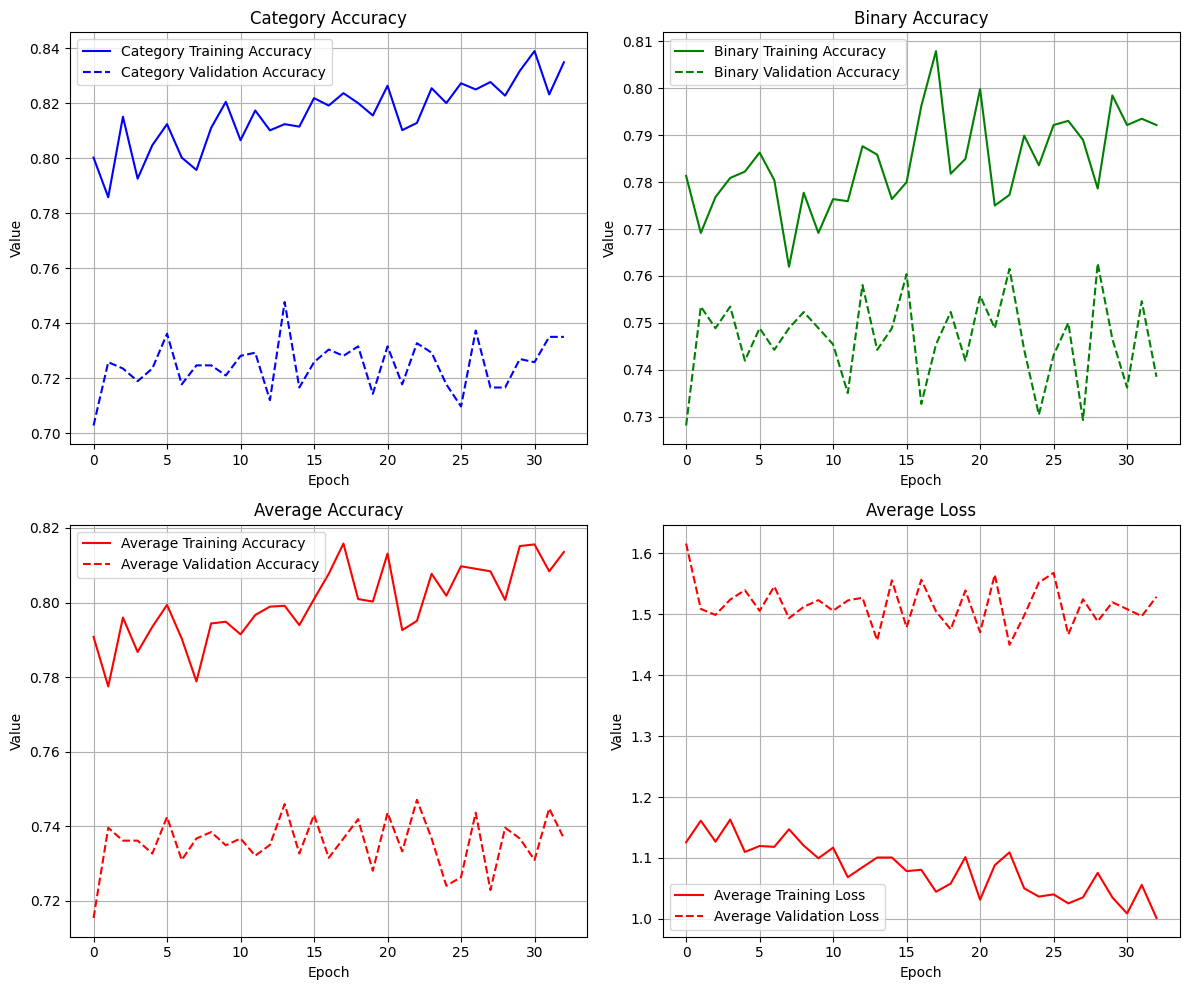

In [ ]:
plot_results(m_history['small_head_base_tuning'])

* **validation loss plateaued at beginning** of training
* **No improvement** in accurcaies or loss
* **Erratic loss curve** could be a sign that learning rate is too high

Let's see if we can achieve a better validation loss by using a lower learning rate

* **Reload base model** to reset weights
* **Learning rate reduced** to 0.000001

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/model_files/model_small_0.3_epoch_24.keras'

build_and_train_model(model_name='model_base_tuning', dropout=0.3, n_epochs=100,
                      early_stopping_patience=10,
                      save_model_weights=True,
                      use_early_stopping=True, weights_path=path,
                      import_weights=True, use_lr_scheduler=False,
                      lr_schedule=0.000001)

In [ ]:
#load the InceptionResNetV2 model with imagenet weights and no top layers
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')
#unfreeze all layers of the base model
base_model.trainable = True

#set the trainable attribute for these blocks
for layer in base_model.layers:
    if any(block_name in layer.name for block_name in final_blocks):
        layer.trainable = True
    else:
        layer.trainable = False

#train the model with the learning rate scheduler
m_history['small_head_base_tuning_lower_lr'] = build_and_train_model(
                                                model_name='model_base_tuning',
                                                dropout=0.3, n_epochs=100,
                                                early_stopping_patience=10,
                                                save_model_weights=True,
                                                use_early_stopping=True,
                                                weights_path=path,
                                                import_weights=True,
                                                lr_scheduler=False,
                                                lr_schedule=0.000001)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 847ms/step - binary_output_accuracy: 0.7701 - category_output_accuracy: 0.7949 - loss: 1.1673 - val_binary_output_accuracy: 0.7396 - val_category_output_accuracy: 0.7166 - val_loss: 1.5382
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - binary_output_accuracy: 0.7690 - category_output_accuracy: 0.8000 - loss: 1.1612 - val_binary_output_accuracy: 0.7546 - val_category_output_accuracy: 0.7350 - val_loss: 1.4767
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - binary_output_accuracy: 0.7946 - category_output_accuracy: 0.7868 - loss: 1.1576 - val_binary_output_accuracy: 0.7546 - val_category_output_accuracy: 0.7166 - val_loss: 1.5263
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - binary_output_accuracy: 0.7628 - category_output_accuracy: 0.8048 - loss: 1.1698 - val_binary_output_accuracy: 0.7350 - val_category_output_accuracy: 0.7247 - val_loss: 1.5414
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - binary_output_ac

* losses plateaued already
* training process is unstable

At this point it is evident that I am **unable to improve the weights and biases** of the base model, either my procedure is inadequate or the parameters are already perfect, either way it is best to **move on with the pre-trained weights**.

### Model evaluation and selection

No improvement was achieved through attempts to tune the base model on the Stanford40 image set so we will proceed with the base model + small head with 0.3 dropout.

In [ ]:
#load the model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/model_files/model_small_0.3_epoch_24.keras')

I have written a new dataloader specifically for loading images for prediction, which can be used for making predictions with the above model on validation, test and future sets of images.

* Batch size 2 - all the **numbers of images** in the image sets for prediction are **divisible by 2**, so this will allow them to be divided into batches with none remaining
* no augmentation - we **want the most accurate predictions possible** so it does not make sense to augment
* resizing - images need to be the **correct size** to be input into the model

In [34]:
def prediction_data_loader(data_frame, img_dir='./data/images/',
                           batch_size=2, target_size=(224, 224)):
    num_images = len(data_frame)
    while True:
      for start in range(0, num_images, batch_size):
          end = min(start + batch_size, num_images)
          batch_data = data_frame.iloc[start:end]

          images = []
          for _, row in batch_data.iterrows():
              img_path = f"{img_dir}/{row['FileName']}"
              img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
              img = tf.keras.preprocessing.image.img_to_array(img)
              img = img / 255.0
              images.append(img)

          yield (np.array(images),)

#create a generator for validation data
val_generator = prediction_data_loader(val_data, batch_size=2)

#calculate steps
steps = len(val_data) // 2

#make predictions
val_predictions = model.predict(val_generator, steps=steps)

450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step


In [ ]:
#extract true labels
true_classes = val_data['Class'].values
true_binary = val_data['MoreThanOnePerson'].values

#process predictions
class_predictions = val_predictions[0]
binary_predictions = val_predictions[1]

#convert class predictions to class labels
predicted_class_indices = np.argmax(class_predictions, axis=1)
predicted_classes = np.array([class_mapping[idx] for idx in predicted_class_indices])

#convert binary predictions to binary labels
predicted_binary = (binary_predictions > 0.5).astype(int).flatten()

#create confusion matrix for class predictions
class_cm = confusion_matrix(true_classes, predicted_classes)

#create confusion matrix for binary predictions
binary_cm = confusion_matrix(true_binary, predicted_binary)

In [ ]:
#print classification report for classes
print("Class Classification Report:")
print(classification_report(true_classes, predicted_classes))

Class Classification Report:
                              precision    recall  f1-score   support

                  applauding       0.52      0.64      0.57        44
             blowing_bubbles       0.79      0.58      0.67        26
              brushing_teeth       0.50      0.79      0.61        14
          cleaning_the_floor       1.00      0.94      0.97        18
                    climbing       0.73      0.97      0.83        31
                     cooking       0.59      0.74      0.66        31
               cutting_trees       0.86      0.75      0.80        16
          cutting_vegetables       0.53      0.60      0.56        15
                    drinking       0.56      0.54      0.55        26
             feeding_a_horse       0.83      0.74      0.78        27
                     fishing       0.88      0.85      0.87        27
               fixing_a_bike       0.94      0.77      0.85        22
                fixing_a_car       0.84      0.84      0.84 

Appears consistent with previously observed metrics, let's inspect the bias from frequency of class.

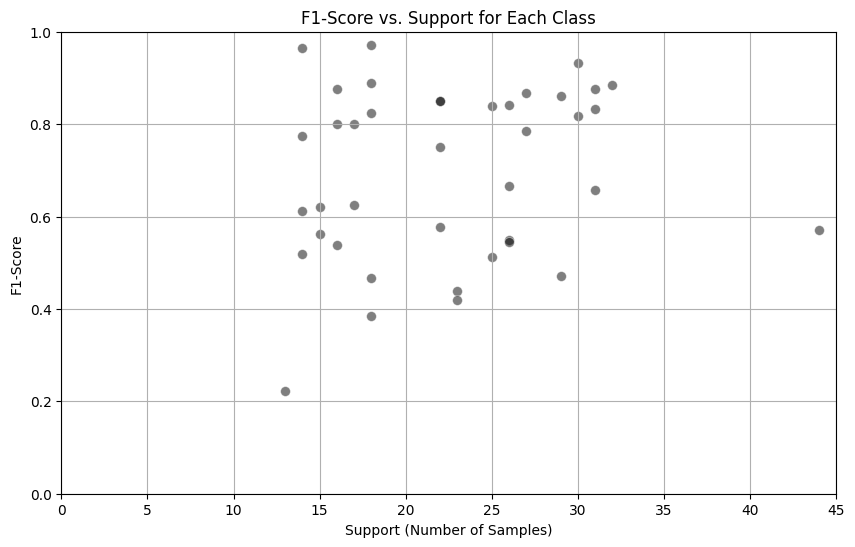

In [ ]:
#save classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

#convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

#extract F1-score and support for each class, excluding 'accuracy', 'macro avg', and 'weighted avg'
f1_scores = report_df.loc[report_df.index.isin(class_names), 'f1-score']
support = report_df.loc[report_df.index.isin(class_names), 'support']

#plot F1-score vs. support
plt.figure(figsize=(10, 6))
sns.scatterplot(x=support, y=f1_scores, color="black", s=50, alpha=0.5)

plt.xlim(0,45)
plt.ylim(0,1)
plt.title('F1-Score vs. Support for Each Class')
plt.xlabel('Support (Number of Samples)')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

Some bias is present but it is not extreme.

In [ ]:
#print classification report for binary prediction
print("\nBinary Classification Report:")
print(classification_report(true_binary, predicted_binary))


Binary Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       316
           1       0.78      0.84      0.81       584

    accuracy                           0.74       900
   macro avg       0.72      0.70      0.71       900
weighted avg       0.74      0.74      0.74       900



For the binary prediction, the model is biased toward achieving higher performance for images with only one person, likely because it has many more images with only one person. F1 score is 20% more for images with only 1 person.

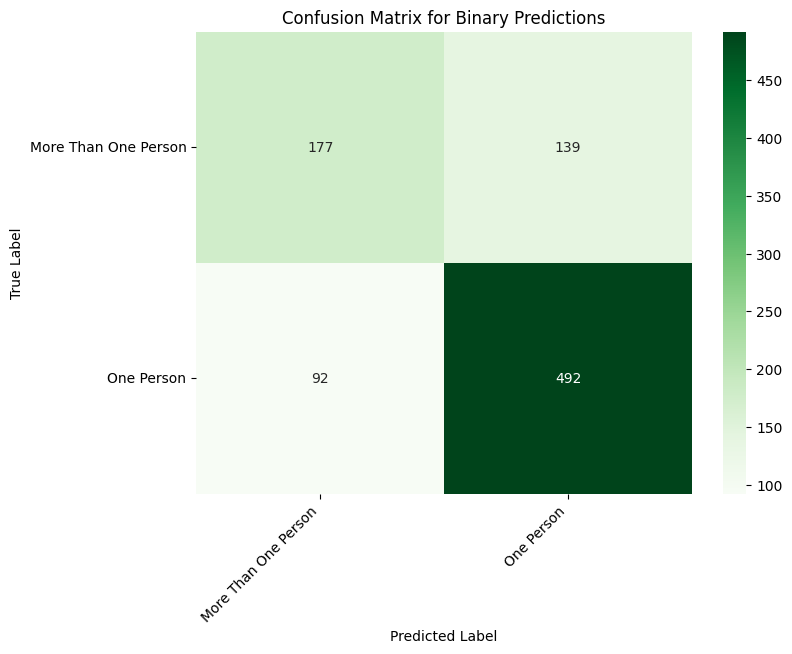

In [ ]:
#define binary class names
binary_class_names = ['More Than One Person', 'One Person']

#plot confusion matrix for binary predictions
plt.figure(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Greens', xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title('Confusion Matrix for Binary Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

This shows how difficult it was for the model to determine how many people were in the image. Also there is nothing glaringly bad here, the model so far checks out.

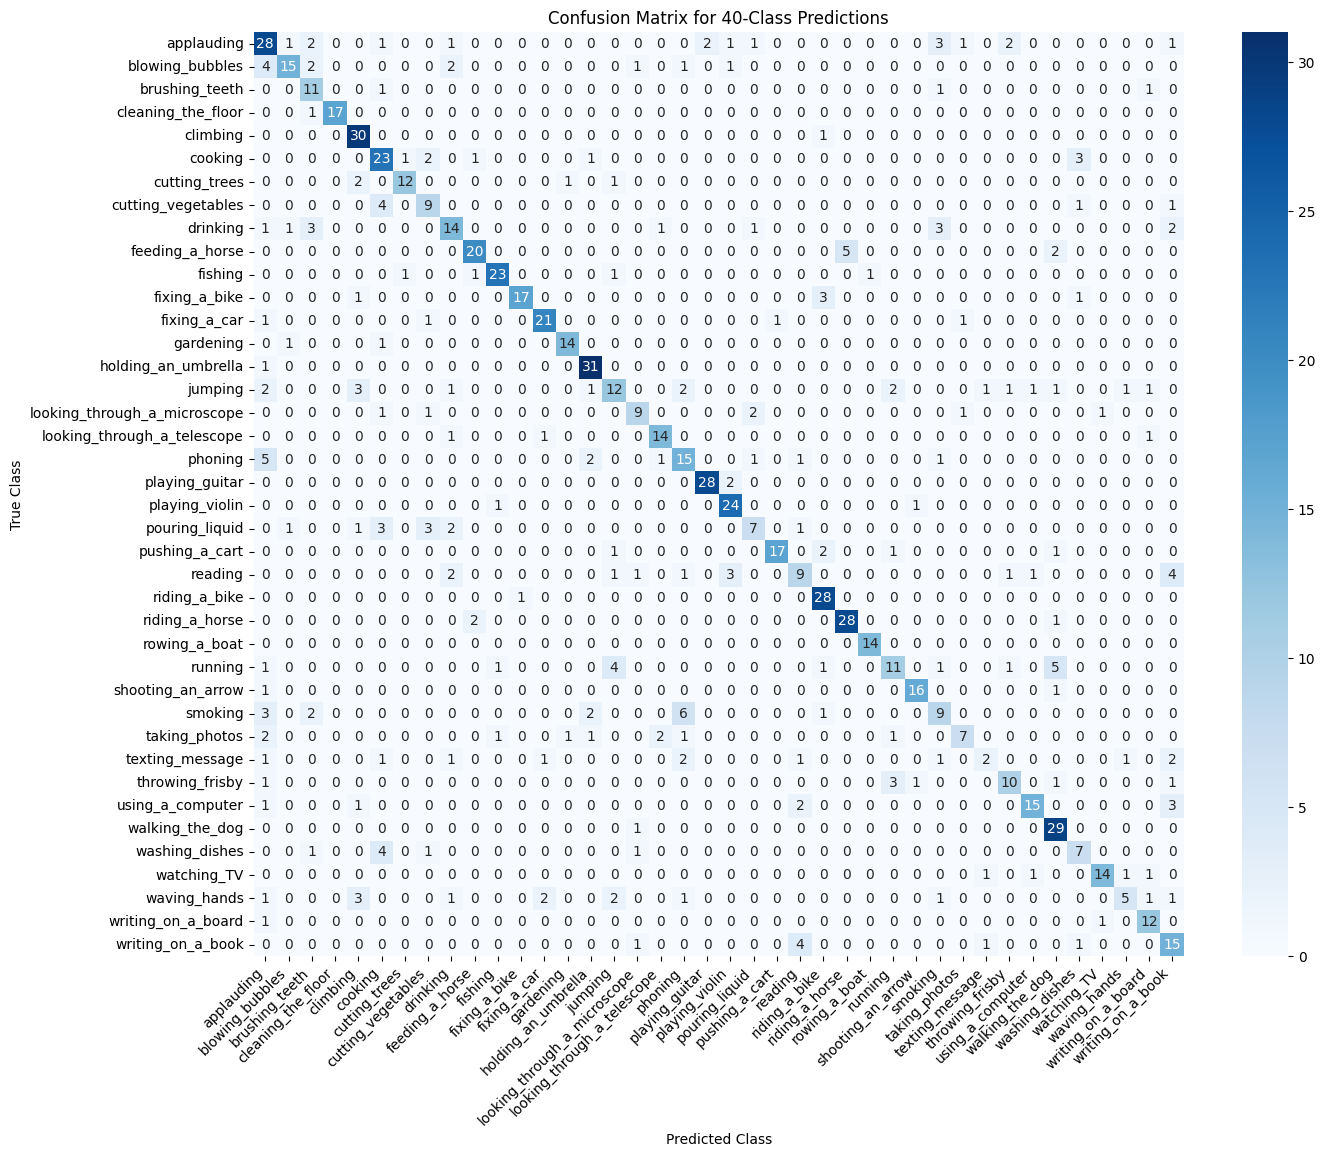

In [ ]:
#extract class names from one-hot encoded columns
class_names = [col.replace('Class_', '') for col in one_hot_encoded_classes.columns]

#plot confusion matrix for class predictions (40 categories)
plt.figure(figsize=(15, 12))
sns.heatmap(class_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 40-Class Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

This looks great! There are no classes that have extremely bad predicitions. Text messaging appears the worst, which was only supported by 13 images. Some common miscategorisations:

* feeding a horse vs riding a horse
* phoning vs smoking
* riding a bike vs fixing a bike
* drinking vs smoking
* running vs walking a dog

These are very reasonable mistakes for the model to make and are a sign that the model is doing a good job of capturing the meaningful patterns in the images.

High level category confusion matrix

In [ ]:
#create a mapping from Class to HighLevelCategory
class_to_high_level_category = val_data[['Class', 'HighLevelCategory']].drop_duplicates().set_index('Class')['HighLevelCategory'].to_dict()
class_to_high_level_category

{'using_a_computer': 'Communication_Technology',
 'waving_hands': 'Social_LeisureActivities',
 'applauding': 'Social_LeisureActivities',
 'holding_an_umbrella': 'AnimalCare',
 'brushing_teeth': 'PersonalCare_Hygiene',
 'fixing_a_car': 'MaintenanceRepair',
 'fishing': 'OutdoorActivities',
 'playing_guitar': 'Artistic_MusicalActivities',
 'riding_a_horse': 'Sports_Recreation',
 'watching_TV': 'Social_LeisureActivities',
 'playing_violin': 'Artistic_MusicalActivities',
 'smoking': 'Social_LeisureActivities',
 'shooting_an_arrow': 'Sports_Recreation',
 'blowing_bubbles': 'Social_LeisureActivities',
 'cleaning_the_floor': 'HouseholdActivities',
 'walking_the_dog': 'OutdoorActivities',
 'jumping': 'Sports_Recreation',
 'pouring_liquid': 'Social_LeisureActivities',
 'climbing': 'OutdoorActivities',
 'looking_through_a_telescope': 'Observation_Exploration',
 'writing_on_a_board': 'Artistic_MusicalActivities',
 'running': 'OutdoorActivities',
 'fixing_a_bike': 'MaintenanceRepair',
 'drinking': 

In [ ]:
#generate true high-level categories
true_high_level_category = [class_to_high_level_category[cls] for cls in true_classes]

#generate predicted high-level categories
predicted_high_level_category = [class_to_high_level_category[cls] for cls in predicted_classes]

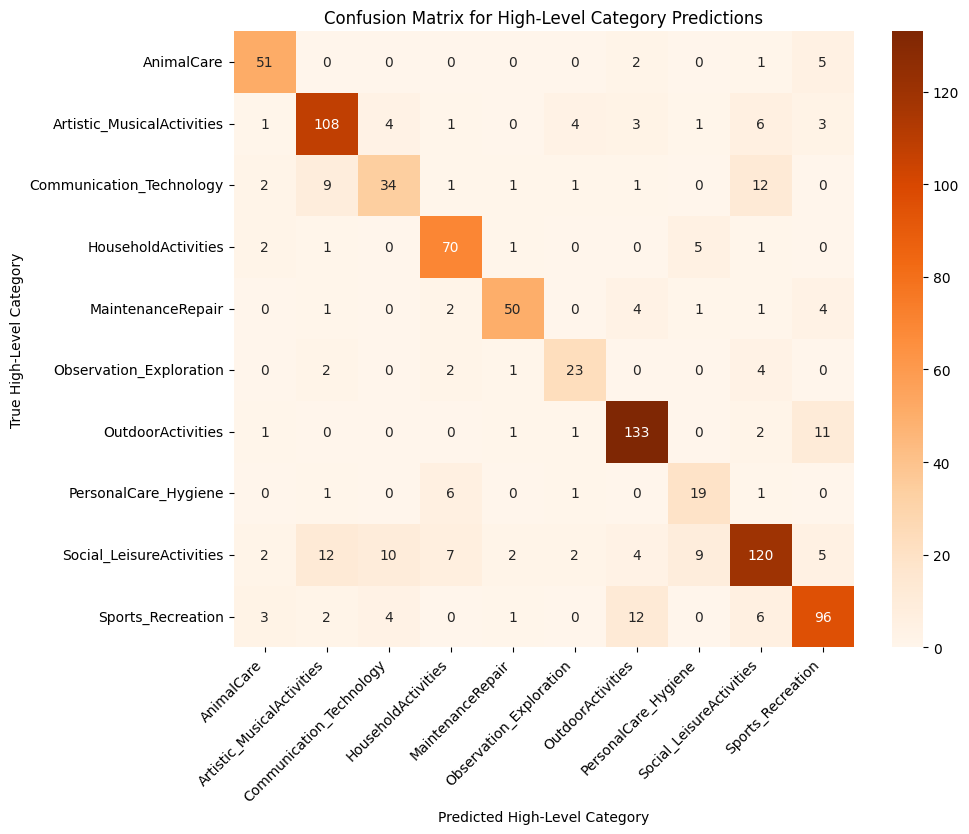

In [ ]:
#create confusion matrix for high-level category predictions
high_level_cm = confusion_matrix(true_high_level_category, predicted_high_level_category)

#get unique high-level categories
high_level_categories = sorted(val_data['HighLevelCategory'].unique())

#plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(high_level_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=high_level_categories, yticklabels=high_level_categories)
plt.title('Confusion Matrix for High-Level Category Predictions')
plt.xlabel('Predicted High-Level Category')
plt.ylabel('True High-Level Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

These high level categories are an exremely useful tool for identifying the themes which the model struggles to differentiate between. It is easily evident that these types of activities are commonly mixed up by the model:

* Sports Recreation vs OutdoorActivites
* Communication Technology vs Social LeasureActivities

As an example, rowing a boat falls into Outdoor Activity but could also fit into Sports Recreation, in other words, this confusion is a likely result of the fact that the model is determining broader themes amungst the images (from relevant features) and using these themes to assist in predicting classes, which is probably very practical most of the time but can also be the cause of misclassification.

In [ ]:
#print classification report for high level category predictions
print("\nHigh Level Category Classification Report:")
print(classification_report(true_high_level_category, predicted_high_level_category))


High Level Category Classification Report:
                            precision    recall  f1-score   support

                AnimalCare       0.82      0.86      0.84        59
Artistic_MusicalActivities       0.79      0.82      0.81       131
  Communication_Technology       0.65      0.56      0.60        61
       HouseholdActivities       0.79      0.88      0.83        80
         MaintenanceRepair       0.88      0.79      0.83        63
   Observation_Exploration       0.72      0.72      0.72        32
         OutdoorActivities       0.84      0.89      0.86       149
      PersonalCare_Hygiene       0.54      0.68      0.60        28
  Social_LeisureActivities       0.78      0.69      0.73       173
         Sports_Recreation       0.77      0.77      0.77       124

                  accuracy                           0.78       900
                 macro avg       0.76      0.77      0.76       900
              weighted avg       0.78      0.78      0.78       900



In [ ]:
#save classification report
report = classification_report(true_high_level_category, predicted_high_level_category, output_dict=True)

#convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

#extract F1-score and support for each class, excluding 'accuracy', 'macro avg', and 'weighted avg'
f1_scores = report_df.loc[report_df.index.isin(high_level_categories), 'f1-score']
support = report_df.loc[report_df.index.isin(high_level_categories), 'support']

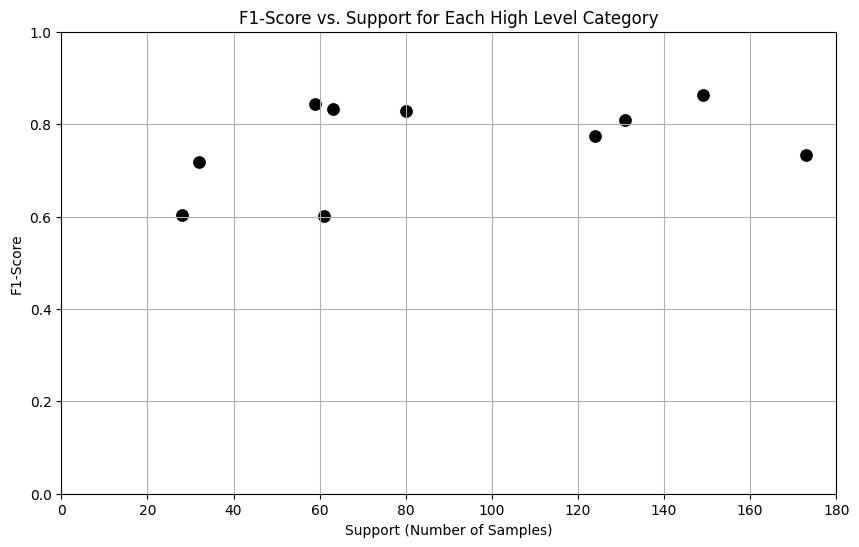

In [ ]:
#plot F1-score vs. support with black dots
plt.figure(figsize=(10, 6))
sns.scatterplot(x=support, y=f1_scores, color="black", s=100)

plt.xlim(0,180)
plt.ylim(0,1)
plt.title('F1-Score vs. Support for Each High Level Category')
plt.xlabel('Support (Number of Samples)')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

Again, these data points may highlight some minor bias due to the number of images in each category, but the bias is minor. Importantly, lower support would correlate with less images from that class or category in the whole training set, as stratification was used to achieve a consistent distribution of classes across the various splits.

In [ ]:
#add a column for predicted classes to your DataFrame
val_data['PredictedClass'] = predicted_classes
val_data['PredictedBinary'] = predicted_binary
val_data['PredictedHighLevelCategory'] = predicted_high_level_category

#filter out misclassified images
misclassified_categories = val_data[val_data['Class'] != val_data['PredictedClass']]
misclassified_binaries = val_data[val_data['MoreThanOnePerson'] != val_data['PredictedBinary']]
misclassified_high_levels = val_data[val_data['HighLevelCategory'] != val_data['PredictedHighLevelCategory']]

In [ ]:
def plot_misclassified_images(misclassified_df, true_label_col,
                              predicted_label_col, title_str, n=36):
    #sample n misclassified images
    sampled_data = misclassified_df.sample(n=n, random_state=rand)

    #create a grid
    grid_size = int(n**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    #flatten the axes array for easy iteration
    axes = axes.flatten()

    #loop through the axes and the sampled data
    for ax, (index, row) in zip(axes, sampled_data.iterrows()):
        #open the image file
        img_path = os.path.join('data/images', row['FileName'])
        img = Image.open(img_path)

        #display the image
        ax.imshow(img)

        #set the title with true and predicted labels
        ax.set_title(f"True: {row[true_label_col]}\nPred: {row[predicted_label_col]}")
        ax.axis('off')  #hide axes

    #adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle(title_str, fontsize=24, y=1.02)  #set a main title for the plot
    plt.show()

In [ ]:
plot_misclassified_images(misclassified_categories,
                          'Class', 'PredictedClass',
                          "Misclassified Categories")

#output removed for github publication as images are not licensed for redistribution

Some **biases can be observed** here, for instance a man working on a car has the car over his head on a hoist. All the other images I have seen of people working on cars had the car on the ground, therefore the model is illequiped to correctly categorise this image. This specific example could be rectified by including more images of people working on cars which are on hoists or have only a small part of the vehicle showing in the image, to give the model more opportunities to learn the features specific to this style of image.

**Other misclassifications** such as writing on a book vs reading a book **are very subjective** in nature and unlikely to be able to be resolved - how can we really know if she is writing or reading if we cannot see the page she is looking at, sometimes this is impossible, even for a human.

In [ ]:
#replace 0 with '> 1 Person' and 1 with 'One Person' in the specified columns
misclassified_binaries['MoreThanOnePerson'] = misclassified_binaries['MoreThanOnePerson'].replace({0: '> 1 Person', 1: 'One Person'})
misclassified_binaries['PredictedBinary'] = misclassified_binaries['PredictedBinary'].replace({0: '> 1 Person', 1: 'One Person'})

plot_misclassified_images(misclassified_binaries,
                          'MoreThanOnePerson', 'PredictedBinary',
                          "Misclassified Binary Predictions")

#output removed for github publication as images are not licensed for redistribution

One issue which is highlighted here is that additional **people are often missed when they are on the side edges** of a landscape image. For example the lady walking a dog or the man drinking from a mug, both on the bottom row. This could potentially be rectified with a more robust rescaling method making use of **padding instead of cropping to retain more of the information** from the image. Padding could introduce its own biasses, but they will be easier to overcome than the critical information being cropped out of the image.

In [ ]:
plot_misclassified_images(misclassified_categories,
                          'HighLevelCategory', 'PredictedHighLevelCategory',
                          "Misclassified High-Level Categories")

#output removed for github publication as images are not licensed for redistribution

The top left is a good example of where the model managed to determine that an outdoor activty was taking place, but it couldn't detect the frisby and the image landed in the Sports Recration bucket.

### Evaluation on test data

In [ ]:
#create a generator for validation data
test_generator = prediction_data_loader(test_data, batch_size=2)

#calculate steps
steps = len(test_data) // 2

#make predictions
test_predictions = model.predict(test_generator, steps=steps)

675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step


In [ ]:
#extract true labels
true_classes = test_data['Class'].values
true_binary = test_data['MoreThanOnePerson'].values

#process predictions
class_predictions = test_predictions[0]
binary_predictions = test_predictions[1]

#convert class predictions to class labels
predicted_class_indices = np.argmax(class_predictions, axis=1)
predicted_classes = np.array([class_mapping[idx] for idx in predicted_class_indices])

#convert binary predictions to binary labels
predicted_binary = (binary_predictions > 0.5).astype(int).flatten()

#create confusion matrix for class predictions
class_cm = confusion_matrix(true_classes, predicted_classes)

#create confusion matrix for binary predictions
binary_cm = confusion_matrix(true_binary, predicted_binary)

In [ ]:
#print classification report for classes
print("Class Classification Report:")
print(classification_report(true_classes, predicted_classes))

Class Classification Report:
                              precision    recall  f1-score   support

                  applauding       0.69      0.76      0.72        67
             blowing_bubbles       0.84      0.78      0.81        40
              brushing_teeth       0.48      0.64      0.55        22
          cleaning_the_floor       0.87      0.96      0.92        28
                    climbing       0.87      0.96      0.91        47
                     cooking       0.76      0.74      0.75        46
               cutting_trees       0.90      0.83      0.86        23
          cutting_vegetables       0.50      0.45      0.48        22
                    drinking       0.65      0.44      0.52        39
             feeding_a_horse       0.83      0.90      0.86        42
                     fishing       0.97      0.93      0.95        41
               fixing_a_bike       0.92      0.69      0.79        32
                fixing_a_car       0.88      0.95      0.91 

75% accuracy is better than the validation set's 71% - the **model has generalised very well**.

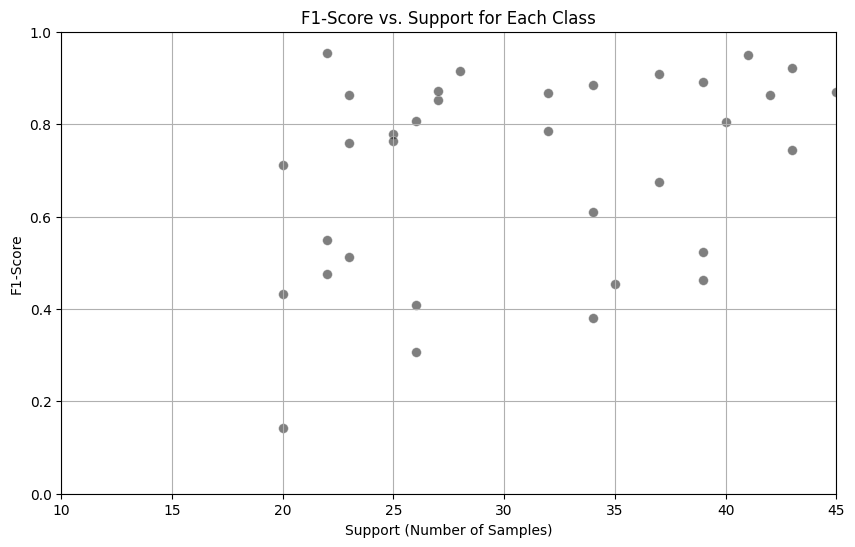

In [ ]:
#save classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

#convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

#extract F1-score and support for each class, excluding 'accuracy', 'macro avg', and 'weighted avg'
f1_scores = report_df.loc[report_df.index.isin(class_names), 'f1-score']
support = report_df.loc[report_df.index.isin(class_names), 'support']

#plot F1-score vs. support
plt.figure(figsize=(10, 6))
sns.scatterplot(x=support, y=f1_scores, color="black", s=50, alpha=0.5)

plt.xlim(10,45)
plt.ylim(0,1)
plt.title('F1-Score vs. Support for Each Class')
plt.xlabel('Support (Number of Samples)')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

Not much bias from frequency of classes.

In [ ]:
#print classification report for binary prediction
print("\nBinary Classification Report:")
print(classification_report(true_binary, predicted_binary))


Binary Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.54      0.61       505
           1       0.76      0.85      0.80       845

    accuracy                           0.74      1350
   macro avg       0.72      0.70      0.70      1350
weighted avg       0.73      0.74      0.73      1350



Accuracy equal to that of the validation set, again - amazing generalisation shown here.

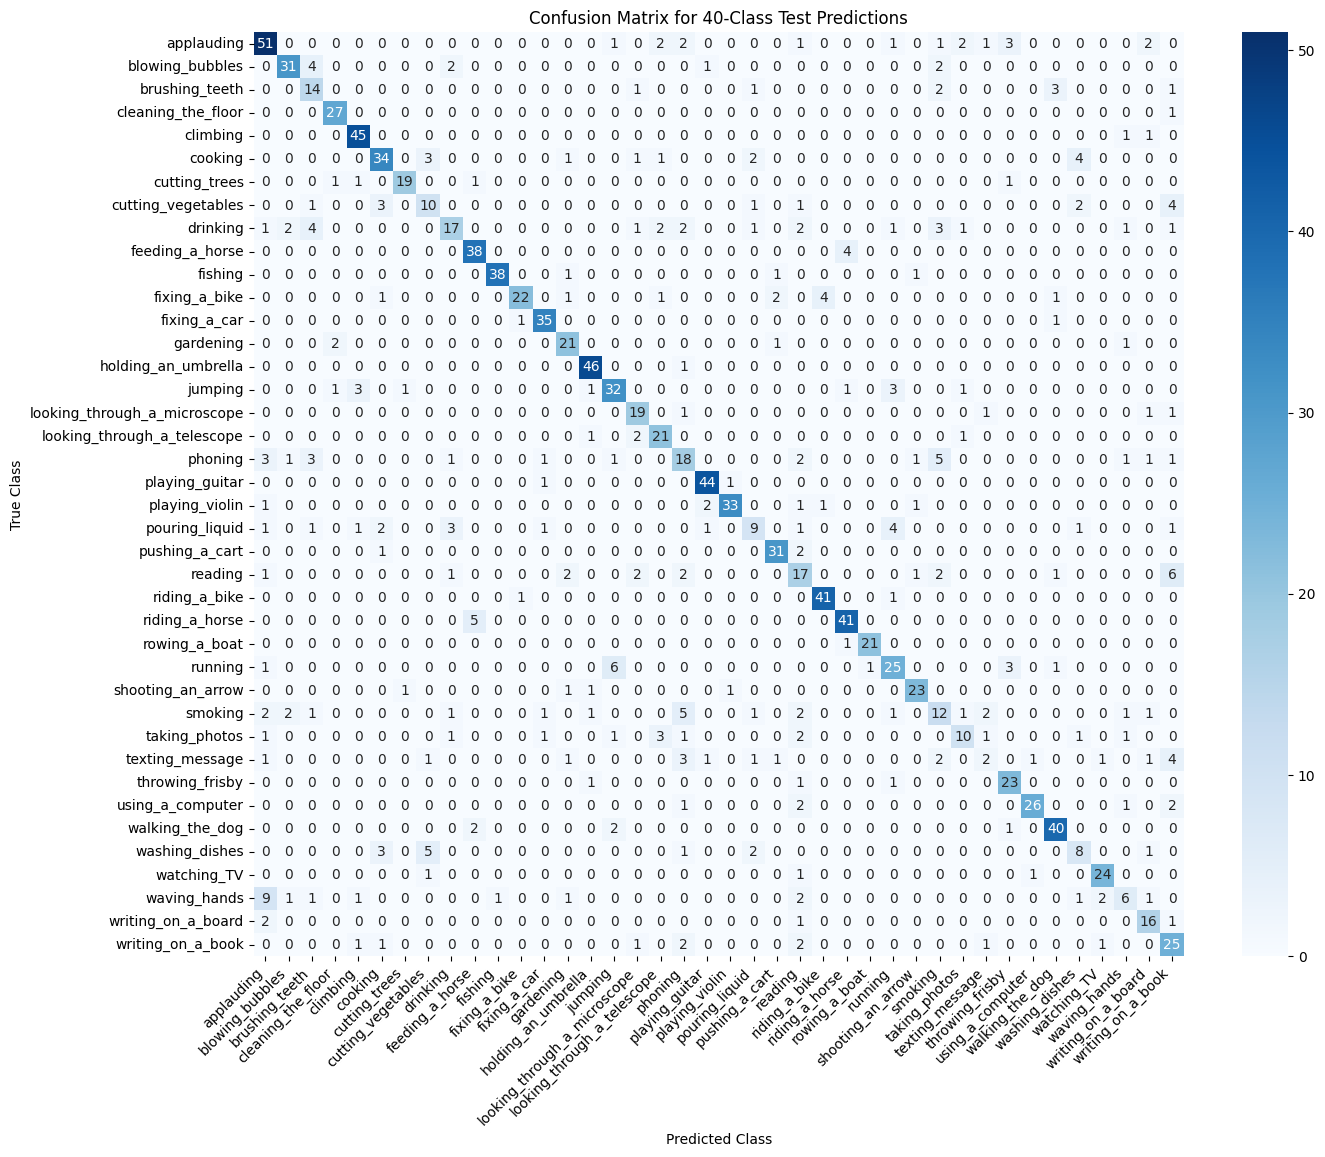

In [ ]:
#plot confusion matrix for class predictions (40 categories)
plt.figure(figsize=(15, 12))
sns.heatmap(class_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 40-Class Test Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Text messaging has proved a difficult class to differentiate, however this is a solid pass for the model.

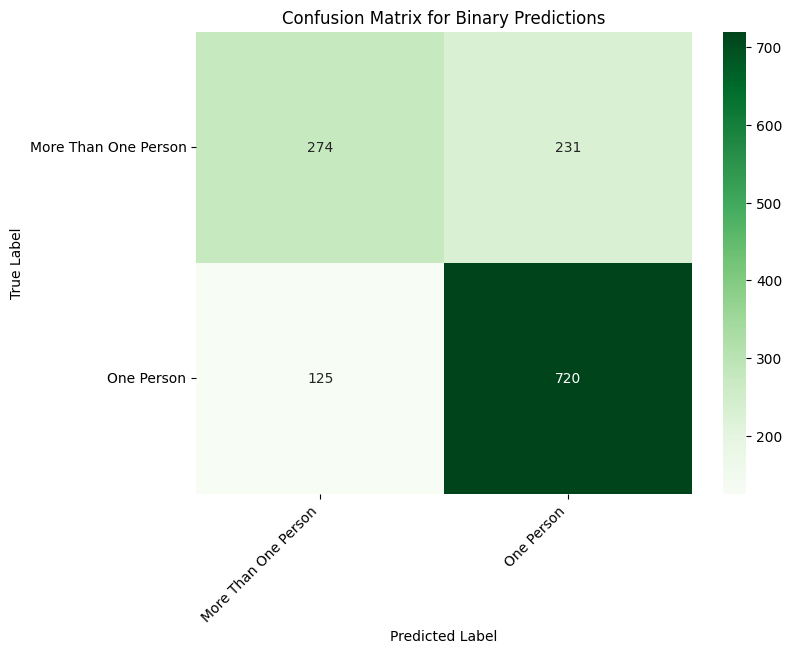

In [ ]:
#plot confusion matrix for binary predictions
plt.figure(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Greens', xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title('Confusion Matrix for Binary Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Similar to validation results, which is what we are looking for to ensure there are no issues with regard to generalisation or data leakage during training.

### Retraining the model on a larger portion of the images

At this stage, we have identified the best performing model architecture and dropout which produces the lowest losses and highest accuracies, however the model was only trained using 50% of the training images in order to reserve images for validation and testing. If I am going to employ this model in the real world, it makes sense to use as many labelled images as we can to train the model, to give it the highest chance of success, by learning from as many images as possible.

I have a few choices to make here:

 * epochs:

I will not have validation data, so I need to make a decision on how many epochs to train the model for before stopping it. The best model scored the lowest validation loss after 24 epochs, with similar models taking 24 and 13 epochs (small_0.4 and small_0.2). Using (2x) more data to train the model effectively regularizes the model, therefore overfitting is less of a concern. Based on the results of training similar models so far, 30 epochs is a reasonable number for training which will allow the model to converge, thereby achieving optimal performance.

 * test set

I am not going to deploy a model to the real world without having some assurance that it will perform as expected, so a small test set is still a good idea. With the thorough testing performed so far and 2x more images provided to the model for training I am confident it will perform well so maximising the training set size is balanced with the need for this assurance by selecting a small test set of 10% of the total images.

In [49]:
#split into train and test datasets
train_data, test_data = train_test_split(image_data, test_size=0.1,
                                         random_state=4,
                                         stratify=image_data['Class'])

train_data.shape

(4050, 44)

In [50]:
test_data.shape

(450, 44)

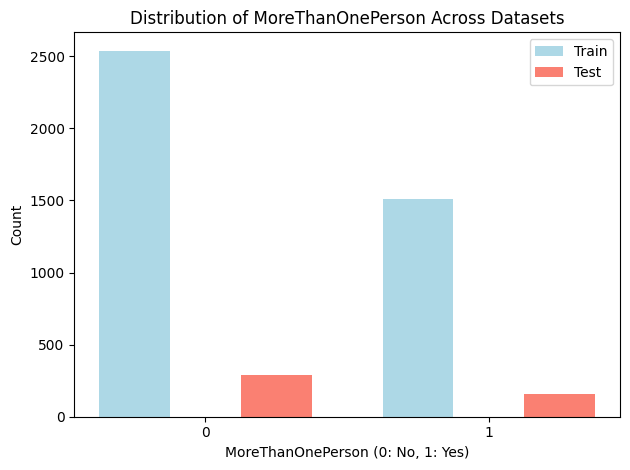

In [21]:
# Count values for MoreThanOnePerson (0s and 1s) in each dataset
train_counts = train_data['MoreThanOnePerson'].value_counts()
test_counts = test_data['MoreThanOnePerson'].value_counts()

# Create a plot
fig, ax = plt.subplots()

# Define bar width and positions
bar_width = 0.25
bar_positions = [0, 1]

# Plotting the bars
ax.bar([p - bar_width for p in bar_positions], train_counts, width=bar_width, label='Train', color='lightblue')
ax.bar([p + bar_width for p in bar_positions], test_counts, width=bar_width, label='Test', color='salmon')

# Adding labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(['0', '1'])
ax.set_xlabel('MoreThanOnePerson (0: No, 1: Yes)')
ax.set_ylabel('Count')
ax.set_title('Distribution of MoreThanOnePerson Across Datasets')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

A quick plot tells us MoreThanOnePerson is fairly balanced across the train/test split.  

Follow the same procedure to predict for the future images, difference being we have no labels.

In [17]:
#as we have different size sets of images, we need to reset the steps per epoch
steps_per_epoch_train = len(train_data) // BATCH_SIZE
steps_per_epoch_test = len(test_data) // BATCH_SIZE

In [53]:
#update image generators according to new data split
train_generator = custom_data_loader(train_data, train_datagen)

In [22]:
m_history['final_model'] = build_and_train_model(
                                        dropout=0.3,
                                        n_epochs=30,
                                        save_model_weights=True,
                                        model_name='final_model',
                                        val_data_provided=False)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 130s 767ms/step - binary_output_accuracy: 0.5937 - category_output_accuracy: 0.1697 - loss: 4.0932 - learning_rate: 1.0000e-04
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 533ms/step - binary_output_accuracy: 0.6248 - category_output_accuracy: 0.5228 - loss: 2.5110 - learning_rate: 1.0000e-04
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step - binary_output_accuracy: 0.6564 - category_output_accuracy: 0.5997 - loss: 2.0647 - learning_rate: 1.0000e-04
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 528ms/step - binary_output_accuracy: 0.6960 - category_output_accuracy: 0.6714 - loss: 1.7743 - learning_rate: 1.0000e-04
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - binary_output_accuracy: 0.7084 - category_output_accuracy: 0.6811 - loss: 1.7113 - learning_rate: 1.0000e-04
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 436ms/step - binary_output_accuracy: 0.7309 - category_output_accuracy: 0.6959 - loss: 1.5887 - learning_rate: 1.0000e-04
Epo

In [25]:
plot_results(m_history['final_model'])

In the interest of avoiding an overfitted model, and considering that during previous model training in this project evaluation losses frequently hit their lowest value before training losses plateuaed, I will take the model from epoch 25 where it achieved maximum average training accuracy.

For this exercise to prove worthwhile, we want to see that this model generalises better to unsees data, thanks to having been trained on a wider range of images, than its earlier counterpart. That means testing its performance on the test dataset and comparing to the prior model's performance on its test dataset.

In [29]:
len(image_data)

4500

In [26]:
#load the model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/model_files/final_model_epoch_25.keras')

In [54]:
#calculate steps
steps = len(test_data) // 2

#create a generator for test data
test_generator = prediction_data_loader(test_data, batch_size=2)

#make predictions
test_predictions = model.predict(test_generator, steps=steps)

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


In [56]:
#extract true labels
true_classes = test_data['Class'].values
true_binary = test_data['MoreThanOnePerson'].values

#process predictions
class_predictions = test_predictions[0]
binary_predictions = test_predictions[1]

#convert class predictions to class labels
predicted_class_indices = np.argmax(class_predictions, axis=1)
predicted_classes = np.array([class_mapping[idx] for idx in predicted_class_indices])

#convert binary predictions to binary labels
predicted_binary = (binary_predictions > 0.5).astype(int).flatten()

#create confusion matrix for class predictions
class_cm = confusion_matrix(true_classes, predicted_classes)

#create confusion matrix for binary predictions
binary_cm = confusion_matrix(true_binary, predicted_binary)

In [57]:
#print classification report for classes
print("Class Classification Report:")
print(classification_report(true_classes, predicted_classes))

Class Classification Report:
                              precision    recall  f1-score   support

                  applauding       0.75      0.68      0.71        22
             blowing_bubbles       0.79      0.85      0.81        13
              brushing_teeth       0.75      0.43      0.55         7
          cleaning_the_floor       1.00      0.89      0.94         9
                    climbing       0.79      0.94      0.86        16
                     cooking       0.86      0.80      0.83        15
               cutting_trees       0.71      0.62      0.67         8
          cutting_vegetables       1.00      0.86      0.92         7
                    drinking       0.50      0.54      0.52        13
             feeding_a_horse       0.93      0.93      0.93        14
                     fishing       0.92      0.79      0.85        14
               fixing_a_bike       0.91      0.91      0.91        11
                fixing_a_car       1.00      0.92      0.96 

In [58]:
#print binary classification report
print("Binary Classification Report:")
print(classification_report(true_binary, predicted_binary))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       159
           1       0.77      0.86      0.81       291

    accuracy                           0.75       450
   macro avg       0.73      0.70      0.71       450
weighted avg       0.74      0.75      0.74       450



We have achieved the same accuracy on the classes but outperformed the prior model on binary classification by 1% supporting the case that this model, trained on a larger portion of the training dataset, has better ability to generalise to unseen data. Having seen the same proportion of each class as the prior model due to both data splits employing stratification, one would not expect more or less bias, but it would be best to check the model for obvious bias as this is the model which will get deployed in the real world.

In [65]:
#save classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

#convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

#extract F1-score and support for each class, excluding 'accuracy', 'macro avg', and 'weighted avg'
f1_scores = report_df.loc[report_df.index.isin(class_names), 'f1-score']
support = report_df.loc[report_df.index.isin(class_names), 'support']

#plot F1-score vs. support
plt.figure(figsize=(10, 6))
sns.scatterplot(x=support, y=f1_scores, color="black", s=50, alpha=0.5)

plt.xlim(0,25)
plt.ylim(0,1)
plt.title('F1-Score vs. Support for Each Class in 10% Test Split')
plt.xlabel('Support (Number of Samples)')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

Naturally, with some classes having very few occurances in the small test set, we have a large range of f1 values, however there is no significant bias, with the model achieving f1 scores ranging from 0.2 to 1 for the least represented classes.

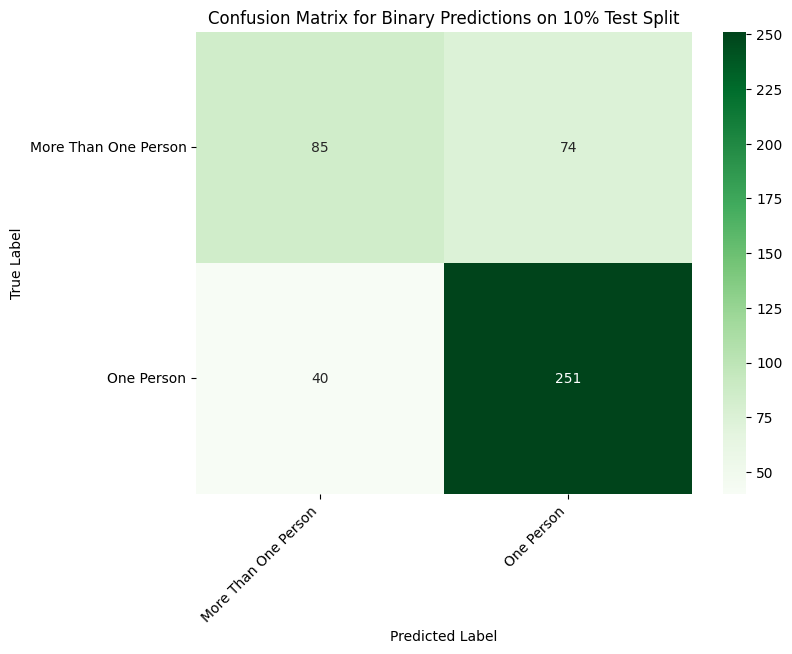

In [64]:
#define binary class names
binary_class_names = ['More Than One Person', 'One Person']

#plot confusion matrix for binary predictions
plt.figure(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Greens', xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title('Confusion Matrix for Binary Predictions on 10% Test Split')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

This plot shows that our model is much better at predicting if there is one person in the image when there is only one person in the image, as also shown in the classification report with an f1 score for this binary classification of 81% The model is far less accurat when there is more than one person in the image, which could be contributed to by the cropping of images during the resizing process. This is not a terminal issue, but something that is important to remember when analysing future predictions after the model is deployed.

In [66]:
#plot confusion matrix for class predictions (40 categories)
plt.figure(figsize=(15, 12))
sns.heatmap(class_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 40-Class Test Predictions on 10% Test Split')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

This is a fairly similar confusion matrix to that of our last test results, showing the model has generalised well and it is at least as safe to deploy this model into the wild as the prior model.

### Prediction for future data

In [67]:
#create a generator for validation data
future_generator = prediction_data_loader(prediction_data, batch_size=2)

#calculate steps
steps = len(prediction_data) // 2

#make predictions
future_predictions = model.predict(future_generator, steps=steps)

1564/1564 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step


In [68]:
#process predictions
class_predictions = future_predictions[0]
binary_predictions = future_predictions[1]

#convert class predictions to class labels
predicted_class_indices = np.argmax(class_predictions, axis=1)
predicted_classes = np.array([class_mapping[idx] for idx in predicted_class_indices])

#convert binary predictions to binary labels
predicted_binary = (binary_predictions > 0.5).astype(int).flatten()

Checking to ensure the predictions are in the correct format - the binary predictions need to be switched back to YES and NO.

In [69]:
predicted_classes

array(['drinking', 'gardening', 'taking_photos', ...,
       'holding_an_umbrella', 'rowing_a_boat', 'cleaning_the_floor'],
      dtype='<U28')

In [70]:
predicted_binary

array([1, 1, 0, ..., 1, 1, 1])

We defined this during preprocessing, and can flip it to get the reverse mapping as desired.

In [71]:
label2_map

{'YES': 0, 'NO': 1}

In [72]:
flipped_dict = {value: key for key, value in label2_map.items()}
flipped_dict

{0: 'YES', 1: 'NO'}

In [73]:
predicted_binary = np.array([flipped_dict[idx] for idx in predicted_binary])
predicted_binary

array(['NO', 'NO', 'YES', ..., 'NO', 'NO', 'NO'], dtype='<U3')

That looks better, let's put them into the predictions CSV and take a look to make sure our predictions look good compared to a few of the images.

In [74]:
prediction_data['Class'] = predicted_classes
prediction_data['MoreThanOnePerson'] = predicted_binary

In [ ]:
#36 random rows from the DataFrame
sampled_data = prediction_data.head(16)

#create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

#flatten the axes array for easy iteration
axes = axes.flatten()

#loop through the axes and the sampled data
for ax, (index, row) in zip(axes, sampled_data.iterrows()):
    #open the image file
    img_path = os.path.join('data/images', row['FileName'])
    img = Image.open(img_path)

    #display the image
    ax.imshow(img)

    #set the title with metadata
    ax.set_title(f"{row['FileName']}\n{row['Class']}\n>1 Person: {row['MoreThanOnePerson']}")
    ax.axis('off')  #hide axes

#adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#output removed for github publication as images are not licensed for redistribution

Although not perfect, there have clearly not been any mixups in the allocation of predicted labels to these images :)

Finally, we can output the predictions.

In [76]:
#save predicition file
path =  "/content/drive/My Drive/DeepLearningAss1/data/s3997902_predictions.csv"
prediction_data.to_csv(path, index=False)

## Discussion

### Ultimate judgement

Three head architectures, various dropout values and different learning rates for base model training were explored. Justification of decisions, analysis of results and selections of the best models were made throughout the resport.

Initially it was planned to identify the best head architecture first and then progress to optimising dropout, however it was discovered that the ideal head could not be selected without first tuning their regularisation. This is because the leading indicator of model performance was validation losses, but it was not evident which architecture would provide the lowest validation losses until they were tested with various dropouts.

The larger of the 3 heads trialled proved to underperform with and without regularisation and so only 2 head configurations were thoroughly tuned. Whilst one architecture proved to provide superior validation losses, other factors also supported its selection including more stable training, and more consistent loss values moving in tandem with training losses which indicated good potential for generalisation.

When tuning upper layers of the base model, models were evaluated on the basis of their ability to improve validation losses and maintain a stable training environment. Two learning rates were trialled, but ultimately the base model could not be improved upon and the pre-trained weights were used for the final model.

Before final selection, the validation performance was evaluated by analysing a variety of visualisations including classification reports, confusion matrices and scatterplots. It was determined from this that the selected model had minimal bias across the classes and was fit for making predicitions on real world images.

### Ethical issues and biases

Various biases have been explored and discussed throughout the report, for example, images of cars being worked on were almost exclusively with the car on the ground with the person laying down or bending over to access the vehicle. This caused the model to be biassed to only identify images of working on cars where the car was on the ground, and when it was presented with a vehicle on a hoist, with a mechanic working on the car above his head, it predicted he was using a camera. This is an example of an action specific bias, resulting in the model overly relying on the presence and location of a vehicle in the image.

Similar themes amung the images have the potential to result in similar biases in predictions made by the model:
* Class imbalance - actions such as text messaging and brushing teeth are less likely to be correctly categorised than actions such as climbing or holding an umbrella
* People who feature in the images are predominantly white - model will be less accurate at predicting actions of people who are not white
* Some activities are predominantly indoors or outdoors - those activities are difficult to detect when they are not in their predominant setting
* The dataset over-represents western demographics, cultural practises and environments - the model has likely learnt associations which could cause poor performance on images of people from under-represented groups or of different cultural context.
* Gender or age bias - Especially within particular classes, people of a particular gender or age range appear to dominate the images, if these are the images which are included in the training data for that class, the model will definitely struggle to categorise people from outside that gender or age range as performing that action. If for example, only images of men are labeled as washing dishes in the training set, then images of women washing dishes are unlikely to be classified correctly.


If the model is used for a real world application, these biases can become an ethical concern, as the application may have undesired impacts as a result of unevenly distributed levels of performance across images of people with different skin colour or who are performing different actions.

### Critical analysis

Approach to model selection, parameter settings and tuning procedured have already been discussed at length throughout the report so this section will focus on limitations and potential improvements.

Potential improvements:
* Use of a higher performing model such as EfficientNet
* Incorporating image augmentation in validation images
* More customised/meaningful tuning of the learning rate, for example as proposed based on validation loss at the end of the hyper-parameter tuning section
* More robust exploration of model head architectures, especially with regard to tapering into the classification layers.
* Implementation of padding to retain more of the original images

Improvements for real world application
* Targetted data augmentation to address skin colour bias
* Targetted augmentation to address imbalance of binary category
* Incorporation of F1 score into the loss metric to counter bias from class imbalance
* Using a multi-branch model where the area of the image containing the person is first identified can provide significant performance improvement

Model Limitations:
* Inherent imbalances of dataset labels
* Small size of dataset for fine tuning
* Rescaling requirements - images need to be cropped or padded to 224x224
* Restricted to predicting only the 40 classes which the images are labelled with.
